In [1]:
!pip install imutils -q

In [2]:
sel = 10

In [3]:
import argparse
import time
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored

from imutils import contours
from PIL import Image as Img
from IPython.display import Image
from skimage import measure

from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")

## Exp

In [4]:
# Noise
from sklearn.datasets import make_blobs
def CreateNoiseImage(input_image):
    global size
    global noise_matrix
    data = make_blobs(n_samples= 2800, n_features= 13, centers= 4, cluster_std =3, random_state=1)
    #plt.figure(figsize=(8,8))
    #plt.scatter(data[0][:,0],data[0][:,1], c = data[1], cmap='rainbow')

    if size==1000:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*860).astype(int)
    elif size== 500:
      data1=(((data[0]-np.min(data[0]))/(np.max(data[0])-np.min(data[0])))*460).astype(int)
    data1[:,1] += 10
    
    noise_matrix = -1*np.ones((size,size,3))
    for i,j in data1[:,:2]:
        noise_matrix[j,i,:] = -5
    
    import matplotlib.pyplot as plt
    """
    im = plt.imread('../Images/img4.jpg')[:size,:size,:] #[:1000,:1000,:]  # img4.jpg
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    """
    fig = plt.figure()
    im = input_image
    plt.figure(figsize=(10,10))
    implot = plt.imshow(im)

    
    plt.scatter(data1[:,0],data1[:,1], c = data[1], cmap='rainbow')
    plt.axis('off')
    plt.savefig("../Images/img4_noise.jpg",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.close()
    out_image = plt.imread("../Images/img4_noise.jpg")
    #plt.show()
    return out_image
#t=CreateNoiseImage(plt.imread('../Images/img4.jpg')[:size,:size,:])

In [5]:
def Calculate_noise(img):
    global width
    global size
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            t = img[i:i+width,j:j+width,:]
            no_5 = (t==-5).sum()
            #pixel_value = np.max(img[i:i+width,j:j+width,:])
            #if pixel_value==-5:
               # print(pixel_value)
            if no_5 <= 3:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-7,-1) # 230
    return img_transition_value

In [6]:
#img = cv2.imread("../Images/img4.jpg")[:size,:size,:]    #[:1000,:1000,:]
def Calculate_transition_matrix(img):
    global noise_matrix
    global width
    global size
    global noise
    mean_img = img.copy()
    img_transition_value = np.zeros((size//width,size//width))
    for i in range(0,size,width):
        for j in range(0,size,width):
            # got all the points
            pixel_value = np.mean(img[i:i+width,j:j+width,:])
            if pixel_value >210:              #200 didn't work
                mean_img[i:i+width,j:j+width,:] = 250
            else:
                mean_img[i:i+width,j:j+width,:] = 0 #pixel_value
    #kernel = np.ones((5,5), np.uint8)
    #img_dilation = cv2.dilate(mean_img, kernel, iterations=1) 
    img_dilation = mean_img.copy()
    img_transition_value=np.where(img_dilation<230,0,255) # 230
    #cv2.imwrite("dilated_5_2.jpg",img_transition_value)  # final image look BGR looks black and white
    img_transition_value=img_transition_value[::width,::width,0]
    img_transition_value=np.where(img_transition_value<120,-80,-1) # 230 
    
    ## noise
    #i1 = cv2.imread("noise1.PNG")
    #i1=cv2.resize(i1,(size,size))
    #img_transition_value = np.minimum(i2,img_transition_value)
    if noise == True:
      i2=Calculate_noise(noise_matrix)
      img_transition_value = np.minimum(img_transition_value,i2 )
    ##
    #print("final reward")
    #sns.heatmap(img_transition_value)
    #plt.show()
    return img_transition_value

In [7]:
def Calculate_transition_matrix(img):
    temp_img = -10*np.ones(img.shape) # -80
    temp_img[img>20] = -1 
    return temp_img
    

In [8]:
def Sweep(Value, Policy,terminators,transition_value):
    # create transition matrix globally that is not possible since we will create dynamic wall
    New_Value = Value.copy()
    delta = 0
    x,y = Value.shape
    for i in range(x):  # x
        left = 0
        right = 0
        top = 0
        bottom = 0
        for j in range(y):  # y
            # (i,j)  
            if (i,j) in terminators:
                pass
            else:
                same= Value[i,j]
                if i==0:
                    left = same
                else:
                    left = Value[i-1,j]
                if i==x-1:
                    right= same
                else:
                    right = Value[i+1,j]
                if j==0:
                    top= same
                else:
                    top = Value[i,j-1]
                if j==y-1:
                    bottom= same
                else:
                    bottom = Value[i ,j+1]
#                 if (i,j) in red:
#                     transition_reward = -10
#                 else:
#                     transition_reward = -1
                transition_reward = transition_value[i,j]
                total_value = Policy[(y)*i+j,0]*(transition_reward+left) + Policy[(y)*i+j,1]*(transition_reward+right) + Policy[(y)*i+j,2]*(transition_reward+top) + Policy[(y)*i+j,3]*(transition_reward+bottom)
                #print(total_value, New_Value[i,j])
                delta = max(delta, np.abs(total_value- Value[i,j]))
                New_Value[i,j] = total_value    
    #print("Sweep")
    return New_Value, delta

In [9]:
def Improve_Policy(Value, Policy):
    New_Policy = Policy.copy()
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    x,y = Value.shape
    for i in range(x):
        for j in range(y):  # y
            # (i,j)  
            left = 0
            right = 0
            top = 0
            bottom = 0
            same= Value[i,j]
            if i==0:
                left = same
            else:
                left = Value[i-1,j]
            if i==x-1:
                right= same
            else:
                right = Value[i+1,j]
            if j==0:
                top= same
            else:
                top = Value[i,j-1]
            if j==y-1:
                bottom= same
            else:
                bottom = Value[i ,j+1]
            my_list = [left,right, top,bottom]
            max_val = max(my_list)
            my_list = np.array(my_list)
            my_list = (my_list==max_val).astype(int)
            my_list = my_list/np.sum(my_list)
            New_Policy[(y)*i+j,:] = my_list
    #print("Improve_Policy")
    return New_Policy

In [10]:
call =0
def Evaluate_value(Value, Policy,theta,terminators,transition_value):
    Policy = Policy.copy()
    theta = theta
    terminators = terminators.copy()
    Policy = Policy.copy()
    global call
    call += 1
    #terminators = (0,1), (0,2),(0,3), (2,0),(2,1),(2,2)
    delta = float(np.inf)
    while delta> theta:
        delta = 0
        Value, delta = Sweep(Value, Policy, terminators,transition_value)
        #print(delta,theta, delta>theta)
    #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    New_Policy = Improve_Policy(Value, Policy)
    if np.all(Policy==New_Policy):
        #print("Evaluate_value_")
        return Value, New_Policy, theta, terminators
    else:
        # repeat
        #print("Evaluate_value")
        return Evaluate_value(Value, New_Policy,theta, terminators,transition_value)

In [11]:
def Calculate_optimal(Grid_shape,no_actions, terminators,img_mask):
    global verbose
    global img
    global find_optimal_CS
    global Charging_time_CS
    global static_quality_score
    global dynamic_quality_score
    global transition_value
    global actual_dynamic_overhead
    global actual_static_overhead # we can't add charging time before we calculate rem overhead
    x,y = Grid_shape
    State_action = np.ones((x*y,no_actions))*(1/no_actions)  #######  L     R     T     B
    Value = np.zeros((x,y))
    theta = 0.1 #0.001
    
    transition_value = Calculate_transition_matrix(img_mask)
#     for i,j in HOME:
#         transition_value[i,j] = 0  
    for no, (i,j) in enumerate(HOME):
        transition_value[i,j] = 0
        if static_quality_score == True or dynamic_quality_score == True:
          if i != 0:
            # not touching left edge
            transition_value[i,j-1] = min(transition_value[i,j-1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if i != 49:
            # not touching right edge
            transition_value[i,j+1] = min(transition_value[i,j+1], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 0:
            # not touching top edge
            transition_value[i-1,j] = min(transition_value[i-1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          if j != 49:
            # not touching bottom edge
            transition_value[i+1,j] = min(transition_value[i+1,j], -1*(actual_static_overhead[no]+actual_dynamic_overhead[no])-1)
          
#     print("REWARD of each state:-")
#     sns.heatmap(transition_value)
#     plt.show()
#     Value[17,24] = 30
#     terminators.append((17,24))
#     print("terminators",terminators)
    
    #transition_value[25,25] = 1
    #img[25*width-10-70:25*width+10-70,25*width-10:25*width+10,:] = 0
    #Value[HOME] = 0 # No matter how low you make it (-4000) this will become optimal point because everywhere else value is calculated

    l,m,th,tr =Evaluate_value(Value,State_action,79, terminators, transition_value) #l:- value function m:- optimal action
    
    if find_optimal_CS == False and dynamic_quality_score== False:
      print('-'*40)
      print("calculating FUTURE REWARD of each state...")
      print("-"*40)
      print(l)
      print('FUTURE REWARD/Value Functions:-')
#     g2=sns.heatmap(l)
#     g2.tick_params(left=False)  # remove the ticks  #tick_params(left=False)  # remove the ticks
#     plt.tight_layout()
#     plt.show()
    

    if dynamic_quality_score == False and verbose != 0:
      f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(18,6))
      g1 = sns.heatmap(transition_value,ax=ax1)
      g1.set_ylabel('')
      g1.set_xlabel('')
      g2 = sns.heatmap(l,ax=ax2)
      g2.set_ylabel('')
      g2.set_xlabel('')
      plt.show()
    
    
#     layout1 = cv.Layout(
#     height=500,
#     width=500
#     )
    if static_quality_score == True and dynamic_quality_score == False:
      # 3d plot
      new_value = (l-np.min(l))/(np.max(l)-np.min(l))
      pd.DataFrame(new_value).iplot(kind='surface',) # layout= layout1)
    
    #print("Calculate_optimal")         # 80 for -100 , 9.5 for -10 , 100 for -1000  60 for -80
    return l,m              

In [12]:
def recheck(x,y):
  global HOME
  global optimal_value
  global AGENT
  global dynamic_quality_score
  global actual_dynamic_overhead
  global actual_static_overhead
  global terminators
  global state
  global battery
  global Overhead_time_CS
  global Charging_time_CS
  global no_steps
  global stats_df
  
  index_no = HOME.index((x,y))
  time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
  rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
  stats_df.loc[index_no,"CS_pos"] = str((x,y))
  stats_df.loc[index_no,"travel_time"] = time_taken
  stats_df.loc[index_no, "rem_overhead"] = rem_overhead
  stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
  if rem_overhead <= 0:
    # means none can be better than this cs.
    # stop
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    print(stats_df)
    if battery == True:
      #print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]} minutes")
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, time taken {time_taken + rem_overhead + Charging_time_CS[index_no]} minutes")
    else:
      print(f"REACHED_DEST [{x},{y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charging_time_CS[index_no]}")
    print('-'*40)
    return
  else:
    # change transition matrix
    #print(f"Overhead on the CS is {Overhead_time_CS[index_no]}")
    #print(f"Time taken to reach the CS is {time_taken}")
    #print(f"No of steps is {no_steps}")
    #print(f"Overhead on reaching CS {(x,y)} is: {rem_overhead} thus Total Time: {time_taken + rem_overhead}")
    #print("Calculating...")
    print(stats_df)
    actual_dynamic_overhead[index_no] = rem_overhead
    actual_static_overhead[index_no]  = Charging_time_CS[index_no]
    state = 112
    """
    Grid_shape = transition_matrix.shape
    no_actions = 4
    
    optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    """

In [13]:
optimal_path = np.zeros((50,50))
collect_pts = []
def trace_path(optimal_value, optimal_policy,initial_pt):
    global optimal_path
    global width 
    global collect_pts
    global dynamic_quality_score
    global Last_CS 
    x,y = initial_pt  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y) or (x,y)== HOME[-1]):
          # we will check once again
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          print("REACHED HOME")
          return
    if x<0 or x>= 50 or y<0 or y>= 50:
        # stop execution
        return
    # Plot
    a1 = width*y
    b1 = width*x
    a2 = width*y + width
    b2 = width*x + width
    
    #
    policy_index = x*50 + y
    l,r,t,b = optimal_policy[policy_index,:]
    max_index = (l,r,t,b).index(max(l,r,t,b)) # pick the first optimal index
    indexes = [i for i,j in enumerate((l,r,t,b)) if j==max(l,r,t,b)]
    max_index = random.choice(indexes)
    if max_index==0:
        # left
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x-1,y))
        optimal_path[x-1:x,y:y+1] += 1
    elif max_index==1:
        # right
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,((a1+a2)//2,b1),((a1+a2)//2,b2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    elif max_index==2:
        # top
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y-1))
        optimal_path[x:x+1,y-1:y] += 1
    elif max_index==3:
        # bottom 
        #cv2.circle(img, ((a1+a2)//2,(b1+b2)//2),3,(0,250,0),2)
        #cv2.line(img,(a1,(b1+b2)//2),(a2,(b1+b2)//2), (0,0,0),3)
        trace_path(optimal_value, optimal_policy,(x,y+1))
        optimal_path[x:x+1,y+1:y+2] += 1
    else:
        print("ERROR")

In [14]:
def draw_path():
    global optimal_path
    global img
    global width
    global size
    print('calculating')
    Full_matrix = (np.repeat(np.repeat(optimal_path,width,axis=0),width,axis=1)*500).astype(int)
    img = ((np.clip((img - Full_matrix.reshape(size,size,1)).astype(int),0,255)).astype(int)).astype(np.uint8)

In [15]:
# def smart_trace():
#     #print('tracing path..')
#     print("="*80)
#     global optimal_value
#     global optimal_policy
#     global width 
#     global size
#     global battery
    
#     global dynamic_quality_score
#     global actual_dynamic_overhead
#     global Last_CS
#     global no_checked_CS
#     global no_steps
#     global stats_df
#     global Overhead_time_CS
#     global HOME
#     global Charging_time_CS
    
#     if width == 20:
#       w = 10
#     elif width == 10:
#       w = 10
#     T =np.argmax(optimal_policy, axis=1)
#     x_dict = {0:-1,1:1,2:0,3:0}
#     y_dict = {0:0,1:0,2:-1,3:1}
#     x_axis=np.vectorize(x_dict.get)(T)
#     y_axis=np.vectorize(y_dict.get)(T)
#     #f_x ,f_y = HOME
#     in_x, in_y = AGENT
#     no_steps = 0
#     if width == 20:
#       r = 2
#     elif width == 10:
#       r = 3
#     while (in_x,in_y) not in HOME: #in_x != f_x or in_y != f_y:
#         no_steps += 1
#         m = w*in_x
#         l = w*in_y
#         cv2.circle(img, ((2*l+w)//2,(2*m+w)//2),r,(0,255,0),5)
#         new_loc = 50*in_x + in_y
#         in_x += x_axis[new_loc]
#         in_y += y_axis[new_loc]
#         #print("action",x_axis[new_loc],y_axis[new_loc])
#         #print("reached",in_x,in_y)
#         if l<0 or l>999 or m <0 or m>999:
#             print('Not found',(2*l + w),(2*m + w))
#             return

 
#     x,y = in_x, in_y  # 48,25
#     if (x,y) in HOME: #== HOME:
#         if dynamic_quality_score == True and (Last_CS != (x,y)) and no_checked_CS != len(actual_dynamic_overhead):
#           # we will check once again
#           no_checked_CS += 1
#           Last_CS = (x,y)
#           recheck(x,y)
#         else:
#           # stop
#           rem_overhead = 0
#           Charge_t = 0
#           if dynamic_quality_score == True:
#             index_no = HOME.index((x,y))
#             time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
#             rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
#             stats_df.loc[index_no,"CS_pos"] = str((x,y))
#             stats_df.loc[index_no,"travel_time"] = time_taken
#             stats_df.loc[index_no, "rem_overhead"] = rem_overhead
#             stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
#             Charge_t = Charging_time_CS[index_no]
#             print(stats_df)
#           if battery == True:
#             print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]+rem_overhead+Charge_t} minutes")
#           else:
#             print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charge_t}")
#           print('-'*40)
#           return


In [16]:
def smart_trace():
    #print('tracing path..')
    print("="*80)
    global optimal_value
    global optimal_policy
    global width 
    global size
    global battery
    
    global dynamic_quality_score
    global actual_dynamic_overhead
    global Last_CS
    global no_checked_CS
    global no_steps
    global stats_df
    global Overhead_time_CS
    global HOME
    global Charging_time_CS
    
    if width == 20:
      w = 10
    elif width == 10:
      w = 10
    T =np.argmax(optimal_policy, axis=1)
    x_dict = {0:-1,1:1,2:0,3:0}
    y_dict = {0:0,1:0,2:-1,3:1}
    x_axis=np.vectorize(x_dict.get)(T)
    y_axis=np.vectorize(y_dict.get)(T)
    #f_x ,f_y = HOME
    in_x, in_y = AGENT
    no_steps = 0
    if width == 20:
      r = 2
    elif width == 10:
      r = 3
    while (in_x,in_y) not in HOME: #in_x != f_x or in_y != f_y:
        no_steps += 1
        m = w*in_x
        l = w*in_y
        #-#cv2.circle(img, ((2*l+w)//2,(2*m+w)//2),r,(0,255,0),5)
        new_loc = 50*in_x + in_y
        in_x += x_axis[new_loc]
        in_y += y_axis[new_loc]
        #print("action",x_axis[new_loc],y_axis[new_loc])
        #print("reached",in_x,in_y)
        if l<0 or l>999 or m <0 or m>999:
            print('Not found',(2*l + w),(2*m + w))
            return

 
    x,y = in_x, in_y  # 48,25
    if (x,y) in HOME: #== HOME:
        if dynamic_quality_score == True and (Last_CS != (x,y)) and no_checked_CS != len(actual_dynamic_overhead):
          # we will check once again
          no_checked_CS += 1
          Last_CS = (x,y)
          recheck(x,y)
        else:
          # stop
          rem_overhead = 0
          Charge_t = 0
          if dynamic_quality_score == True:
            index_no = HOME.index((x,y))
            time_taken = -1* optimal_value[AGENT[0],AGENT[1]]
            rem_overhead = max(0,Overhead_time_CS[index_no] - time_taken)
            stats_df.loc[index_no,"CS_pos"] = str((x,y))
            stats_df.loc[index_no,"travel_time"] = time_taken
            stats_df.loc[index_no, "rem_overhead"] = rem_overhead
            stats_df.loc[index_no, "total time"] = time_taken + rem_overhead + Charging_time_CS[index_no]
            Charge_t = Charging_time_CS[index_no]
            print(stats_df)
          if battery == True:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, time taken {-1*optimal_value[AGENT[0],AGENT[1]]+rem_overhead+Charge_t} minutes")
          else:
            print(f"REACHED_DEST [{in_x},{in_y}] in {no_steps} steps, with reward of {optimal_value[AGENT[0],AGENT[1]]-rem_overhead-Charge_t}")
          print('-'*40)
          return


In [17]:
def Calculate_Cost(index):
    global drag
    global state
    global HOME
    global AGENT
    global optimal_value
    global img
    global Grid_shape
    global no_action
    global terminators
    global optimal_path
    global width
    global size
    global optimal_policy
    global time_limit
    
    global dj
    
    img_mask = dj #-#cv2.imread("img4.jpg")[:size,:size,:]
    terminators = [(index[0],index[1])]
    HOME = terminators
    v,p= Calculate_optimal(Grid_shape,no_actions, terminators,img_mask)
    return v,p

In [18]:
# called_No = 0
# x1 = 0
# y1 = 0
# def Optimize_CS(image):
#     global called_No 
#     global non_path_reward  #-80
#     global tile_size
#     global x1, y1
#     List_indices = []
#     List_costs = []
    
#     img_mask = image #-#cv2.imread("img4.jpg")[:size,:size,:]
#     transition_value =image #-# Calculate_transition_matrix(img_mask)
#     """
#     HOME = [(3,3)]
#     for i,j in HOME:
#         transition_value[i,j] = 0
#     """
#     mask = transition_value> non_path_reward+2
#     #print(np.where(mask==1))
#     # pick tile_size which can divide 50 like 10/50/2 etc
#     no_subcell = 2

#     #tile_size = 16
#     if called_No == 0:
#         # first time     
#         x1 = 0
#         y1 = 0
#     else:
#         tile_size = 8
        
        
#     for i in range(0,no_subcell):
#         for j in range(0,no_subcell):
#             # (i,j)
#             # pick su
#             x,y = np.where(mask[x1+ i*tile_size: x1+ i*tile_size+tile_size, y1+ j*tile_size:y1 + j*tile_size+tile_size])
#             x =  (i*tile_size) + x
#             y =  (j*tile_size) + y
#             my_list = list(zip(x,y))
#             if my_list == []:
#                 print("no road here")
#             else:
#                 print(my_list)
#                 length = len(my_list)
#                 if length %2 != 0:
#                     # odd no of terms
#                     middle = my_list[(length-1)//2]
#                 else:
#                     # even no of terms
#                     middle = my_list[(length//2) -1]
#                 temp_transition_value = (transition_value[i*tile_size: i*tile_size+tile_size, j*tile_size: j*tile_size+tile_size]).copy()
#                 print(f"Calculating cost for {middle}")
#                 temp_transition_value[middle[0]-(i*tile_size),middle[1]-(j*tile_size)] = 10
#                 plt.figure(figsize=(3,2))
#                 sns.heatmap(temp_transition_value)
#                 plt.show()
                
#                 List_indices.append(middle)
#                 v,p = Calculate_Cost(middle)
#                 cost = np.sum(v[mask])
#                 List_costs.append(cost)
#                 #print(np.random.choice(my_list, size=8))
#                 print(middle,"=",cost)
#             print("#"*80)
#     print(List_indices)
#     print("+"*40)
#     print(List_costs)
#     print("+"*40)
#     print("Optimal CS location")
#     print(List_indices[List_costs.index(max(List_costs))], max(List_costs))
#     Calculate_Cost(List_indices[List_costs.index(max(List_costs))])
    
#     #-#
#     a,b = List_indices[List_costs.index(max(List_costs))] # indices of max cost
#     if a> x1 + tile_size:
#         x1 += tile_size 
#     if b > y1 + tile_size:
#         y1 += tile_size
#     called_No += 1
#     if called_No == 2:
#         return [List_indices[List_costs.index(max(List_costs))]]
#     else:
#         return Optimize_CS(image)

In [19]:
def Optimize_CS(image):
    global verbose
    global called_No 
    global non_path_reward  #-80
    global tile_size
    global x1, y1
    List_indices = []
    List_costs = []
    
    img_mask = image #-#cv2.imread("img4.jpg")[:size,:size,:]
    transition_value =image #-# Calculate_transition_matrix(img_mask)
    """
    HOME = [(3,3)]
    for i,j in HOME:
        transition_value[i,j] = 0
    """
    mask = transition_value> non_path_reward+2
    #print(np.where(mask==1))
    # pick tile_size which can divide 50 like 10/50/2 etc
    no_subcell = 2

    tile_size = 16
    if called_No == 0:
        # first time     
        x1 = 0
        y1 = 0
    else:
        tile_size = 8
    for i in range(0,no_subcell):
        for j in range(0,no_subcell):
            # (i,j)
            # pick su
            x,y = np.where(mask[x1+ i*tile_size: x1+ i*tile_size+tile_size, y1+ j*tile_size:y1 + j*tile_size+tile_size])
            x =  (i*tile_size) + x # since we have 2d aray flattended to 1d
            y =  (j*tile_size) + y
            my_list = list(zip(x,y))
            if my_list == []:
                if verbose != 0:
                    print("no road here")
            else:
                if verbose != 0:
                    print("this is road")
                    print([(x1+i,y1+j) for i,j in my_list])
                length = len(my_list)
                if length %2 != 0:
                    # odd no of terms
                    middle = my_list[(length-1)//2]
                else:
                    # even no of terms
                    middle = my_list[(length//2) -1]
                temp_transition_value = (transition_value[x1 + i*tile_size: x1 + i*tile_size+tile_size, y1 + j*tile_size: y1 + j*tile_size+tile_size]).copy() # picking a 1/4th for display
                if verbose != 0:
                    print(f"Calculating cost for {middle[0]+x1, middle[1]+y1}")
                temp_transition_value[middle[0]-(i*tile_size),middle[1]-(j*tile_size)] = 10 #mapping 1d back to 2d
                if verbose != 0:
                    plt.figure(figsize=(3,2))
                    sns.heatmap(temp_transition_value)
                    plt.show()
                
                List_indices.append(middle)
                v,p = Calculate_Cost(middle)
                if verbose != 0:
                    print(mask.shape, v.shape)
                cost = np.sum(v[mask])
                List_costs.append(cost)
                #print(np.random.choice(my_list, size=8))
                if verbose != 0:
                    print(middle[0]+x1 , middle[1]+y1,"=",cost)
            if verbose != 0:
                print("#"*80)
    if verbose != 0:
        print([(x1+i,y1+j) for i,j in List_indices])
        print("+"*40)
        print(List_costs)
        print("+"*40)
        print("Optimal CS location")
    t = List_indices[List_costs.index(max(List_costs))]
    if verbose != 0:
        print(t[0]+x1, t[1]+ y1,":", max(List_costs))
    Calculate_Cost(List_indices[List_costs.index(max(List_costs))])
    
    #-#
    a,b = List_indices[List_costs.index(max(List_costs))] # indices of max cost
    if a> x1 + tile_size:
        x1 += tile_size 
    if b > y1 + tile_size:
        y1 += tile_size
    called_No += 1
    if called_No == 2:
        return [List_indices[List_costs.index(max(List_costs))]]
    else:
        return Optimize_CS(image)

In [20]:
non_path_reward = -80 #-80
tile_size = 10
#
size =  32 #1000 #1000 #500
width= 1
noise = False
battery = False
find_optimal_CS = True
static_quality_score = False
dynamic_quality_score = False
demo = False
##############################
tile_size = 16 #-#
drag = False
Last_CS = (-100,-100) # something which is not in 50*50
HOME =  [] #0
AGENT = 0
Grid_shape = (32,32) #-#(20,20) #(50,50) #(100,100) # later set automatically
no_actions = 4
terminatos = []
optimal_path = np.zeros((50,50))
non_path_reward = -80
#################################
if size== 1000:
  width = 20
elif size==500:
  width = 10
w = 10

In [21]:
#!pip install plotly
#!pip install cufflinks
from plotly import __version__
print(__version__)
import cufflinks as cv
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected=True)
cv.go_offline()
#pd.DataFrame(new_value).iplot(kind='surface',)

5.6.0


In [22]:
# verbose= 0
# for bbox in bbox_list:
#     bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
#     bbox_resized = cv2.resize(bbox_img, (32,32), interpolation = cv2.INTER_AREA)
    
#     # bbox_resized is my Image 
#     dj = bbox_resized
#     called_No = 0
#     x1 = 0
#     y1 = 0
#     print("Got Value:")
#     HOME = Optimize_CS(bbox_resized)
#     # Calculate path cost
#     img_mask = bbox_resized
#     optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
#     if verbose != 0:
#         sns.heatmap(optimal_value)
#         plt.show()
#         new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
#         pd.DataFrame(new_value).iplot(kind='surface',)
#     print(optimal_value[0,0], optimal_value[-1,0], optimal_value[0,-1], optimal_value[-1,-1], "sum: ",optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1] )
#     #break
#     """
#     #AGENT
#     FROM = [(0,0),(31,0),(0,31),(31,31)]
#     total_sum = 0
#     for i in range(4):
#         AGENT = FROM[i]

#         #smart_trace()
#         new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
#         pd.DataFrame(new_value).iplot(kind='surface',)
#     print("Net")
#     print(total_sum)
#     """
    
        

#     display(Img.fromarray((bbox_resized).astype(np.uint8)))
#     print("="*40)

In [23]:
called_No = 0
verbose = 0
dj = 0
optimal_policy= 0
def get_pieces(img_path):
    global called_No 
    global verbose 
    global dj
    global optimal_policy
    global AGENT
    
    image = cv2.imread(img_path, 0)
    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    labels = measure.label(thresh,background = 0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue

        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        if numPixels > 300:
            mask = cv2.add(mask, labelMask)
    
    bbox_list = []

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    print(f'Found {len(cnts)} contours / numbers')
    backtorgb = cv2.cvtColor(image.astype('float32'), cv2.COLOR_GRAY2RGB)

    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        bbox_list.append([x, y, w, h])
        cv2.rectangle(backtorgb, (x,y), (x+w, y+h), (255,0,0), 5)

    print(f'BBoxes coordinates: {bbox_list}')
    
    verbose= 0
    for bbox in bbox_list:
        bbox_img = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
        bbox_resized = cv2.resize(bbox_img, (32,32), interpolation = cv2.INTER_AREA)

        # bbox_resized is my Image 
        dj = bbox_resized
        called_No = 0
        x1 = 0
        y1 = 0
        #print("Got Value:")
        HOME = Optimize_CS(bbox_resized)
        # Calculate path cost
        img_mask = bbox_resized
        optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
        """
        for k in range(2):
            for t in range(2):
                t1= 0
                t2 = 0
                if k==1:
                    t1 = -1 
                if t == 1:
                    t2 = -1
                AGENT = (t1,t2)
                smart_trace()
        """
        if verbose != 0:
            sns.heatmap(optimal_value)
            plt.show()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print(round(optimal_value[0,0],2), round(optimal_value[-1,0],2), round(optimal_value[0,-1],2), round(optimal_value[-1,-1],2), "sum: ", round((optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1]),2) )
        #break
        """
        #AGENT
        FROM = [(0,0),(31,0),(0,31),(31,31)]
        total_sum = 0
        for i in range(4):
            AGENT = FROM[i]

            #smart_trace()
            new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
            pd.DataFrame(new_value).iplot(kind='surface',)
        print("Net")
        print(total_sum)
        """



        display(Img.fromarray((bbox_resized).astype(np.uint8)))
        print("="*40)

In [24]:
called_No = 0
verbose = 1 #0
dj = 0
optimal_policy= 0
def Image_array(image):
    global called_No 
    global verbose 
    global dj
    global optimal_policy
    global AGENT
    
    # bbox_resized is my Image 
    dj = np.array(image.resize( (32,32)))
    called_No = 0
    x1 = 0
    y1 = 0
    #print("Got Value:")
    HOME = Optimize_CS(dj)
    # Calculate path cost
    img_mask = dj
    optimal_value,optimal_policy = Calculate_optimal(Grid_shape,no_actions, HOME,img_mask)
    """
    for k in range(2):
        for t in range(2):
            t1= 0
            t2 = 0
            if k==1:
                t1 = -1 
            if t == 1:
                t2 = -1
            AGENT = (t1,t2)
            smart_trace()
    """
    if verbose != 0:
        sns.heatmap(optimal_value)
        plt.show()
        new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
        pd.DataFrame(new_value).iplot(kind='surface',)
    print(round(optimal_value[0,0],2), round(optimal_value[-1,0],2), round(optimal_value[0,-1],2), round(optimal_value[-1,-1],2), "sum: ", round((optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1]),2) )
    #break
    """
    #AGENT
    FROM = [(0,0),(31,0),(0,31),(31,31)]
    total_sum = 0
    for i in range(4):
        AGENT = FROM[i]

        #smart_trace()
        new_value = (optimal_value-np.min(optimal_value))/(np.max(optimal_value)-np.min(optimal_value))
        pd.DataFrame(new_value).iplot(kind='surface',)
    print("Net")
    print(total_sum)
    """



    display(Img.fromarray((dj).astype(np.uint8)))
    print("="*40)
    
    return round(optimal_value[0,0],2), round(optimal_value[-1,0],2), round(optimal_value[0,-1],2), round(optimal_value[-1,-1],2),  round((optimal_value[0,0]+ optimal_value[-1,0]+optimal_value[0,-1]+ optimal_value[-1,-1]),2) 

In [25]:
from sklearn.model_selection import train_test_split
Test_Set = pd.read_csv("../input/digit-recognizer/test.csv").iloc[sel*1000: (sel+1)*1000]

In [26]:
test_pre = np.zeros((Test_Set.shape[0],5))
test_pre.shape

(1000, 5)

# Modifying Test Set

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

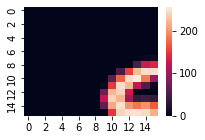

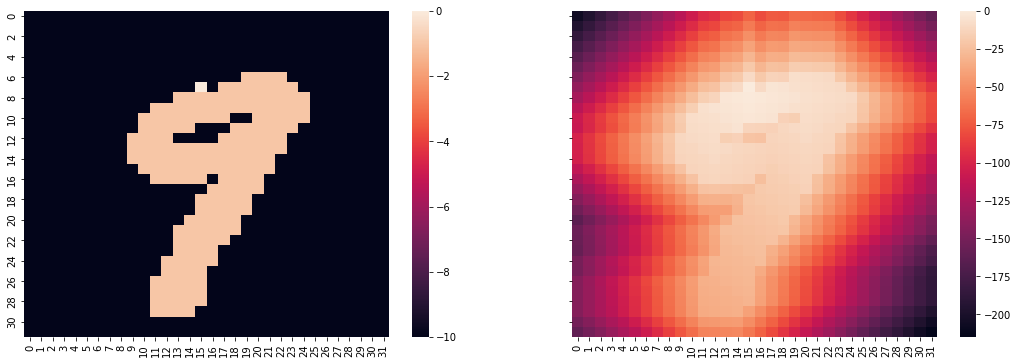

(32, 32) (32, 32)
7 15 = -75931.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

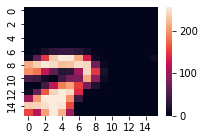

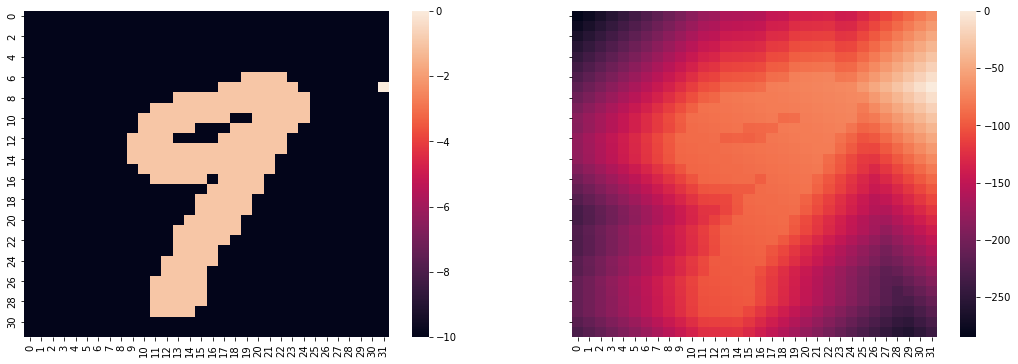

(32, 32) (32, 32)
7 31 = -137658.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), 

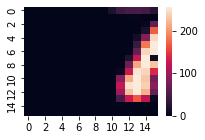

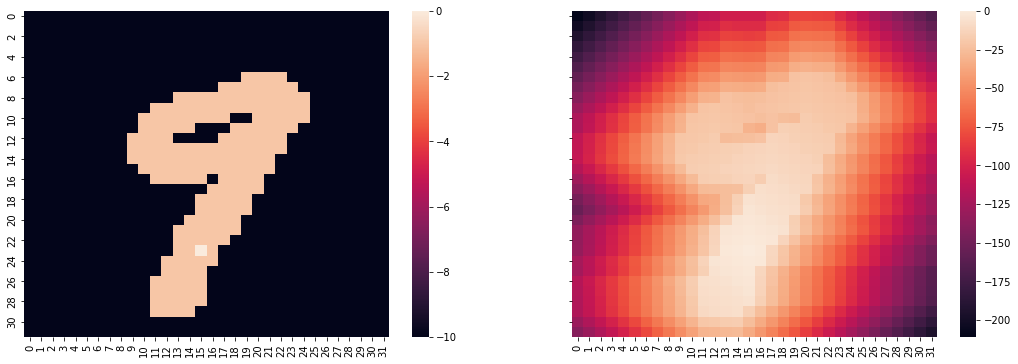

(32, 32) (32, 32)
23 15 = -72669.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

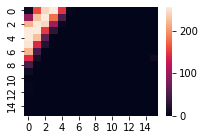

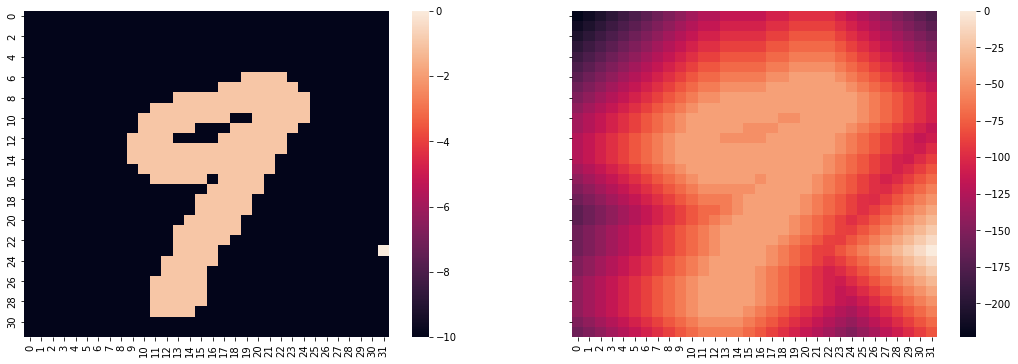

(32, 32) (32, 32)
23 31 = -87766.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-75931.0, -137658.0, -72669.0, -87766.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
23 15 : -72669.0


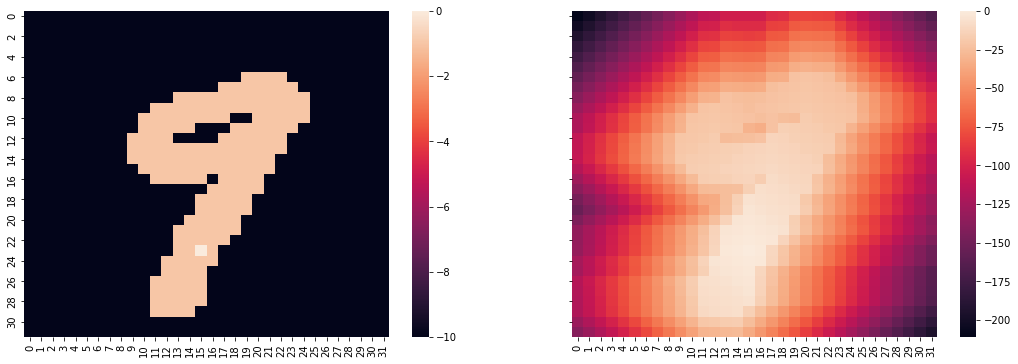

this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7)]
Calculating cost for (19, 7)


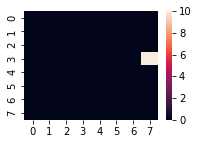

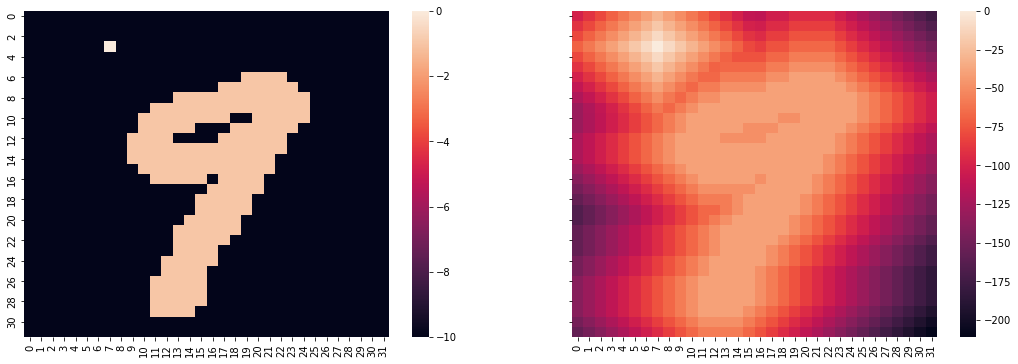

(32, 32) (32, 32)
19 7 = -84857.0
################################################################################
this is road
[(16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15)]
Calculating cost for (19, 15)


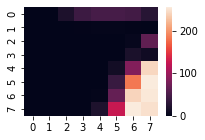

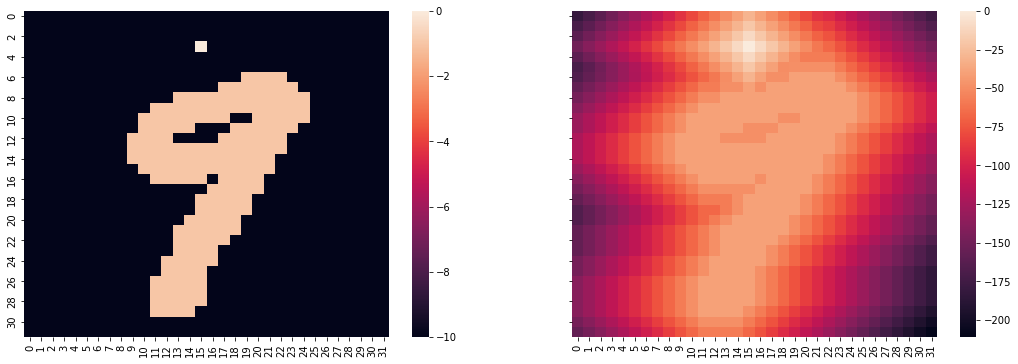

(32, 32) (32, 32)
19 15 = -88633.0
################################################################################
this is road
[(24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (27, 0), (27, 1), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (29, 0), (29, 1), (29, 2), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (31, 0), (31, 1), (31, 2), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7)]
Calculating cost for (27, 7)


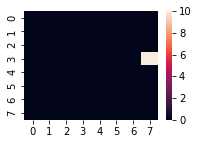

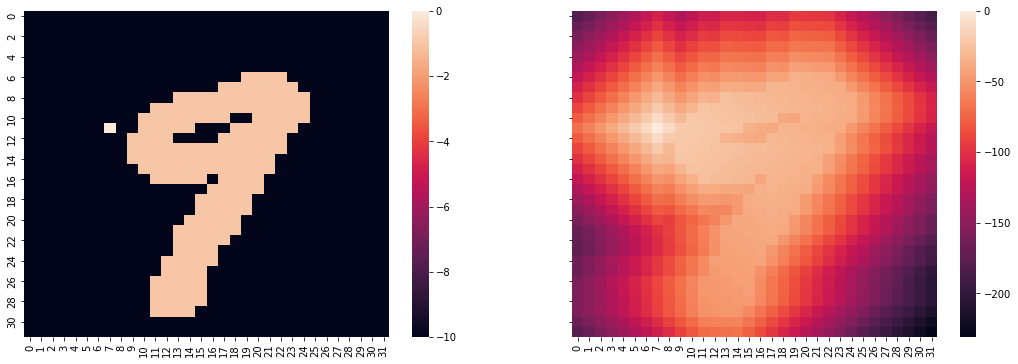

(32, 32) (32, 32)
27 7 = -89552.0
################################################################################
this is road
[(24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 8), (29, 9), (29, 10), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15)]
Calculating cost for (27, 15)


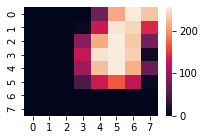

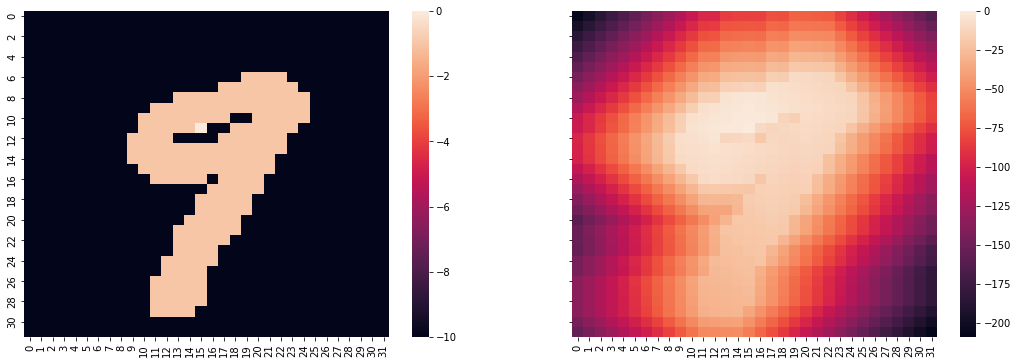

(32, 32) (32, 32)
27 15 = -74191.0
################################################################################
[(19, 7), (19, 15), (27, 7), (27, 15)]
++++++++++++++++++++++++++++++++++++++++
[-84857.0, -88633.0, -89552.0, -74191.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
27 15 : -74191.0


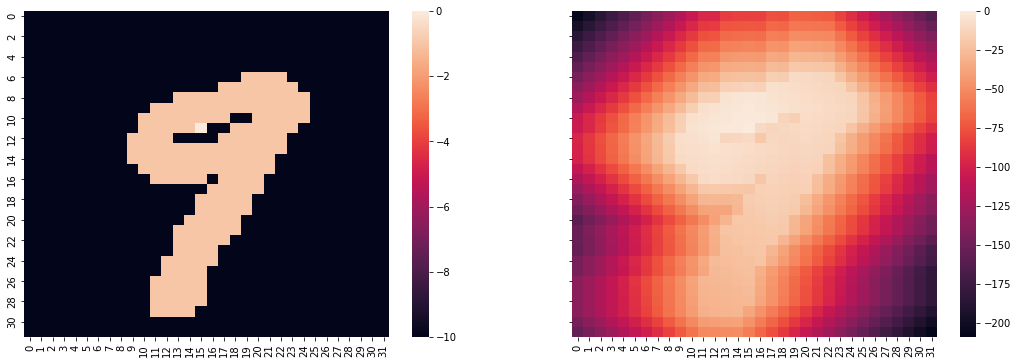

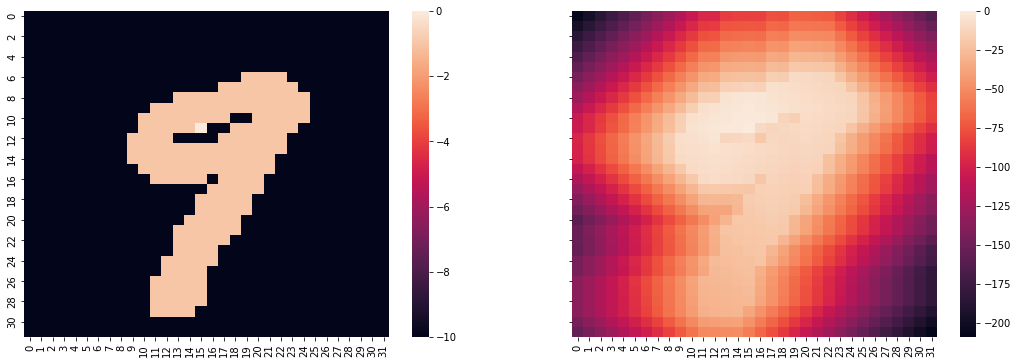

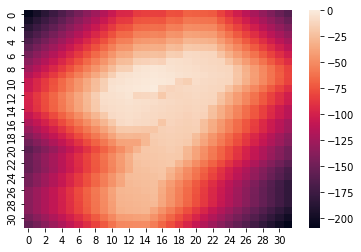

-206.0 -155.0 -162.0 -209.0 sum:  -732.0


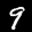

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

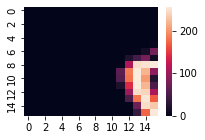

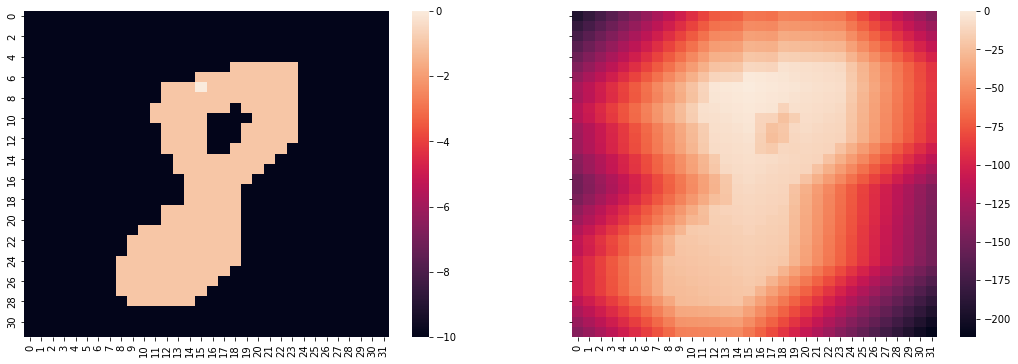

(32, 32) (32, 32)
7 15 = -67870.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

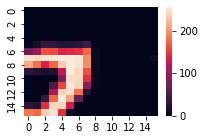

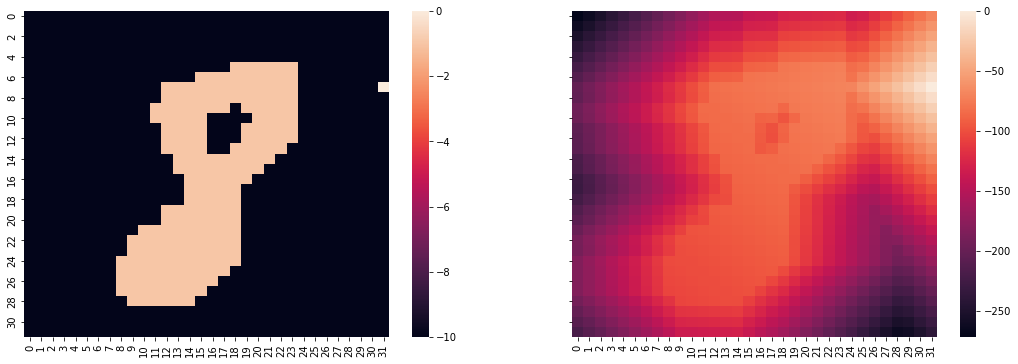

(32, 32) (32, 32)
7 31 = -133619.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), 

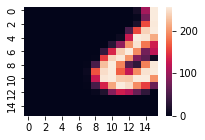

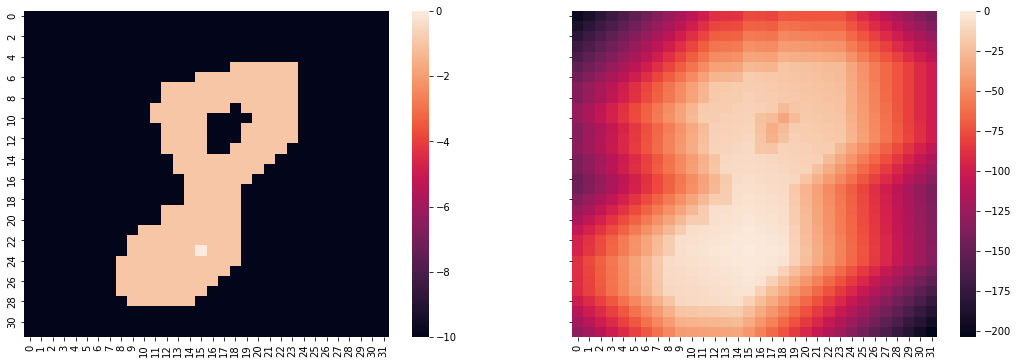

(32, 32) (32, 32)
23 15 = -66998.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

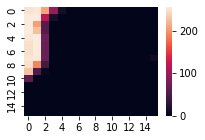

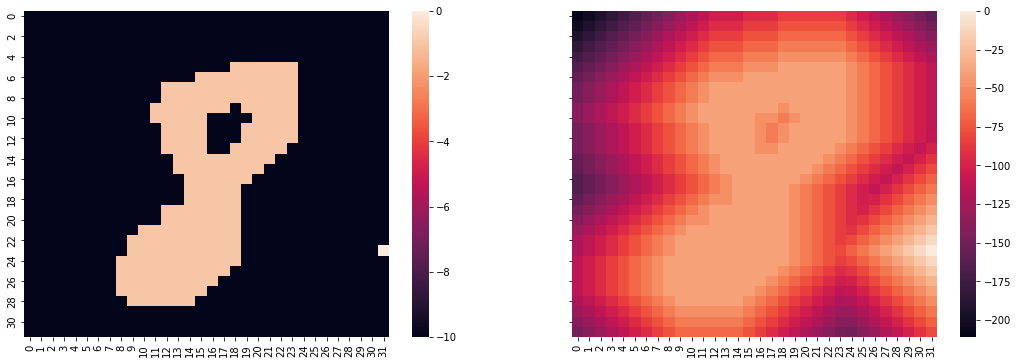

(32, 32) (32, 32)
23 31 = -81441.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-67870.0, -133619.0, -66998.0, -81441.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
23 15 : -66998.0


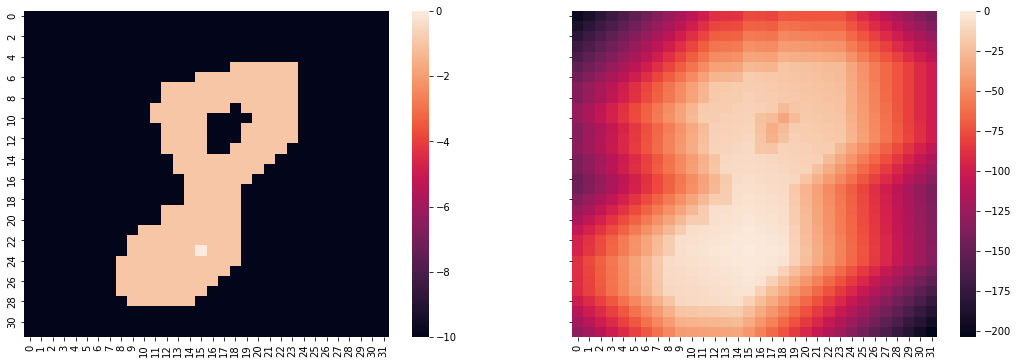

this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7)]
Calculating cost for (19, 7)


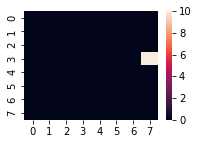

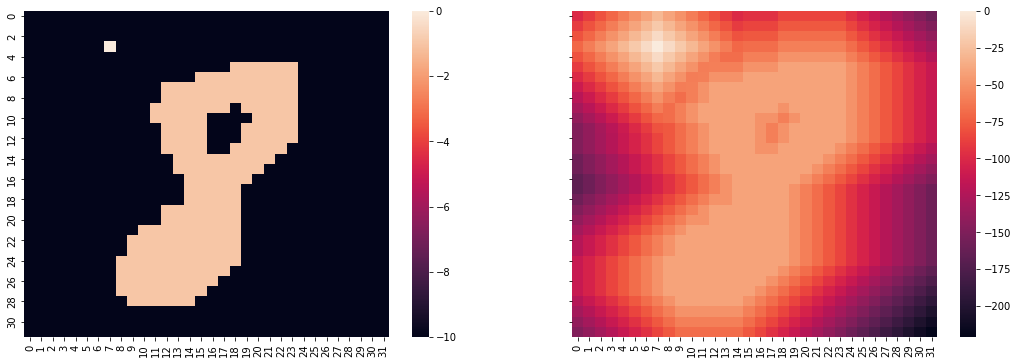

(32, 32) (32, 32)
19 7 = -83008.0
################################################################################
this is road
[(16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15)]
Calculating cost for (19, 15)


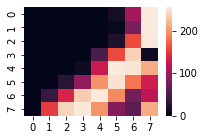

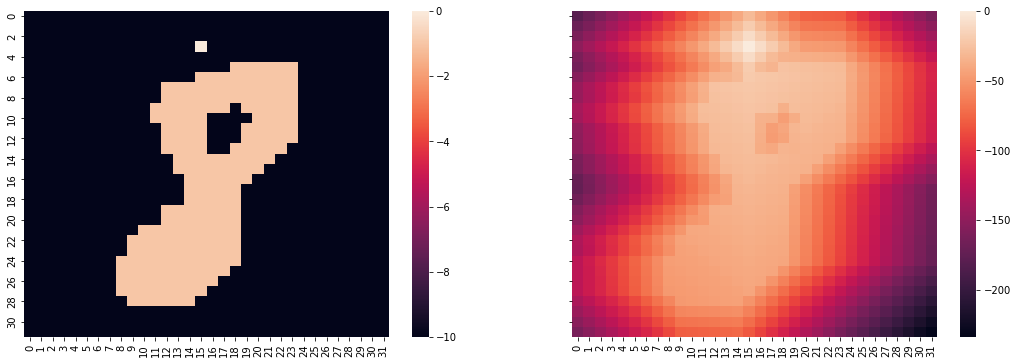

(32, 32) (32, 32)
19 15 = -87014.0
################################################################################
this is road
[(24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (27, 0), (27, 1), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (29, 0), (29, 1), (29, 2), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (31, 0), (31, 1), (31, 2), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7)]
Calculating cost for (27, 7)


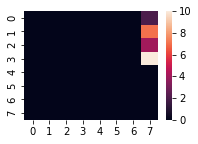

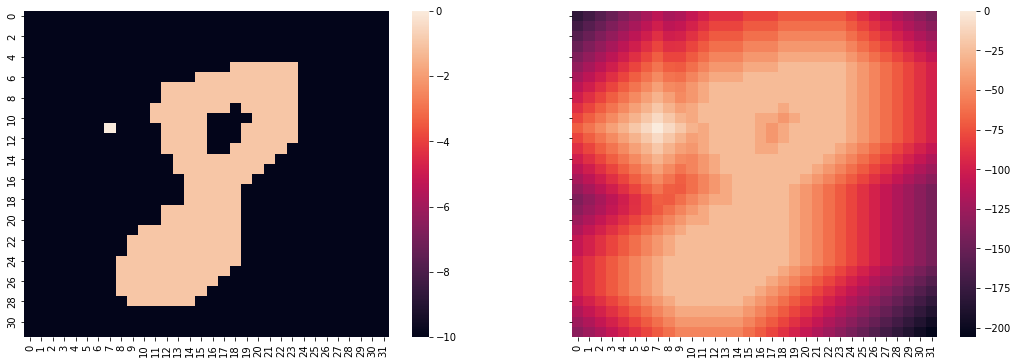

(32, 32) (32, 32)
27 7 = -70351.0
################################################################################
this is road
[(24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 8), (29, 9), (29, 10), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15)]
Calculating cost for (27, 15)


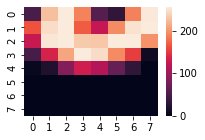

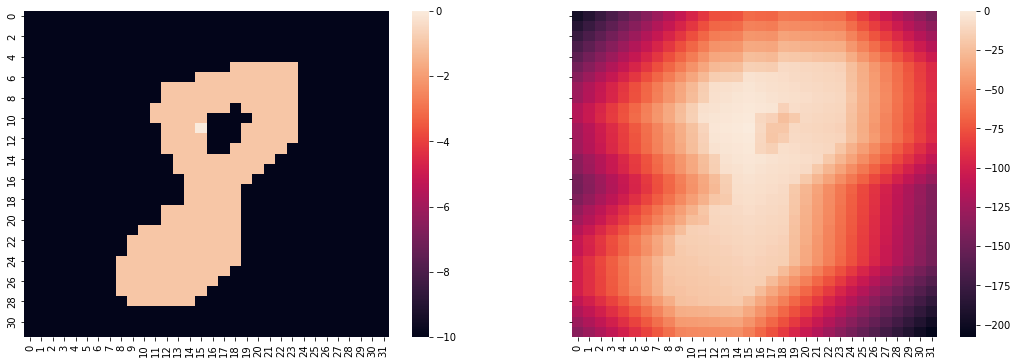

(32, 32) (32, 32)
27 15 = -66442.0
################################################################################
[(19, 7), (19, 15), (27, 7), (27, 15)]
++++++++++++++++++++++++++++++++++++++++
[-83008.0, -87014.0, -70351.0, -66442.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
27 15 : -66442.0


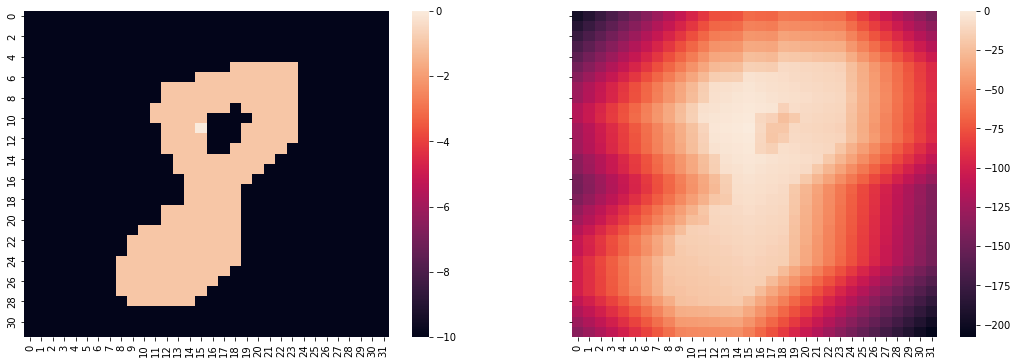

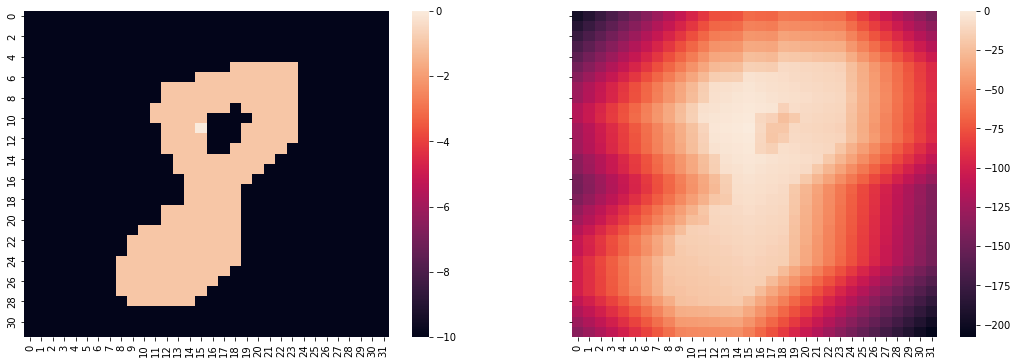

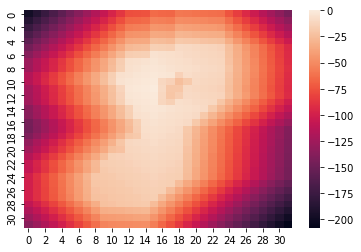

-197.0 -136.0 -144.0 -208.0 sum:  -685.0


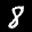

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

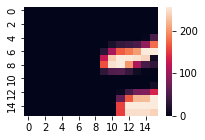

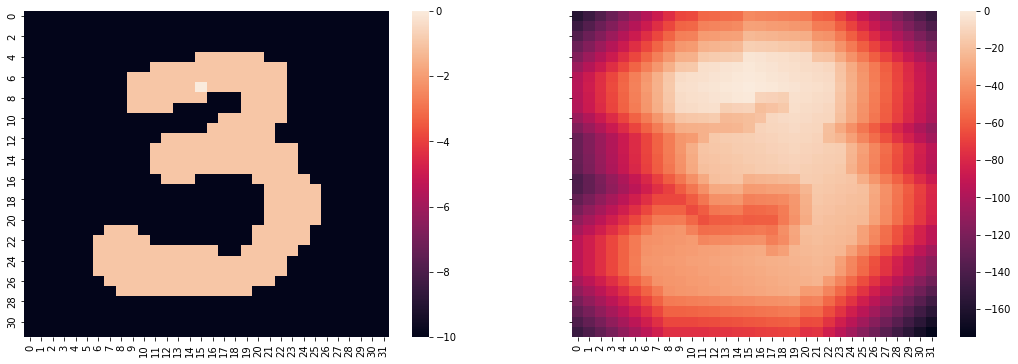

(32, 32) (32, 32)
7 15 = -57467.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

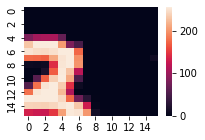

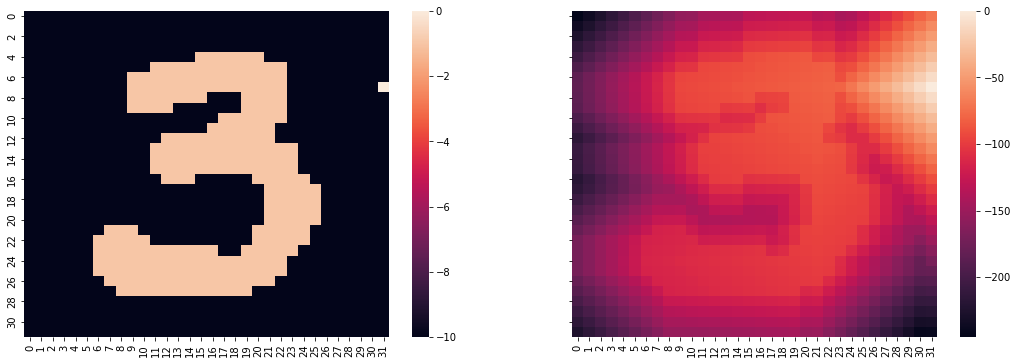

(32, 32) (32, 32)
7 31 = -128202.99999999997
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), 

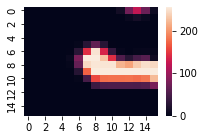

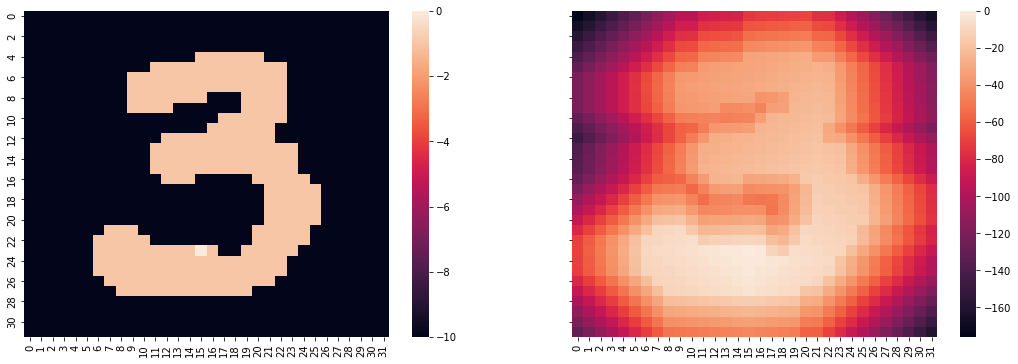

(32, 32) (32, 32)
23 15 = -58087.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

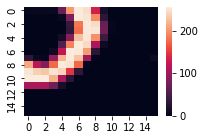

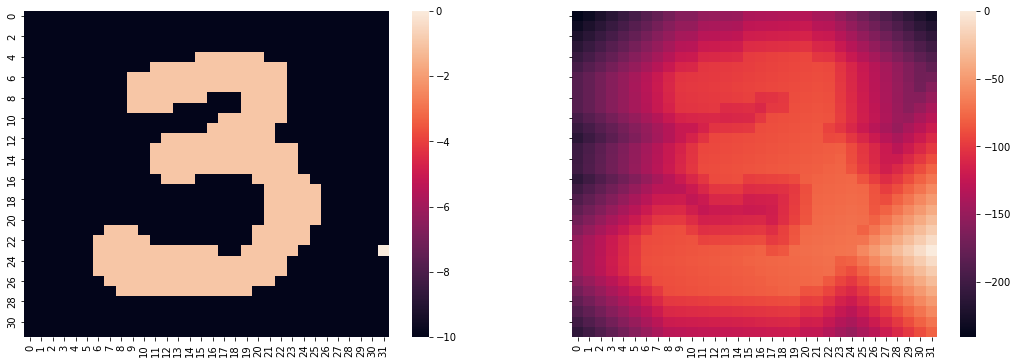

(32, 32) (32, 32)
23 31 = -119519.99999999999
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-57467.0, -128202.99999999997, -58087.0, -119519.99999999999]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
7 15 : -57467.0


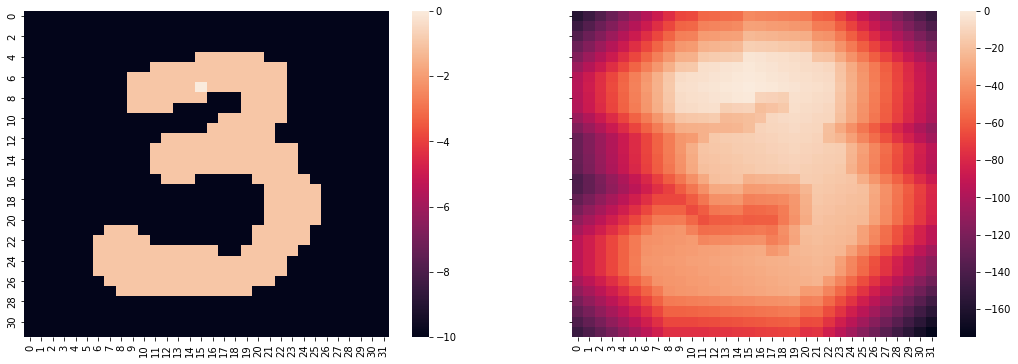

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Calculating cost for (3, 7)


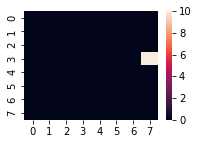

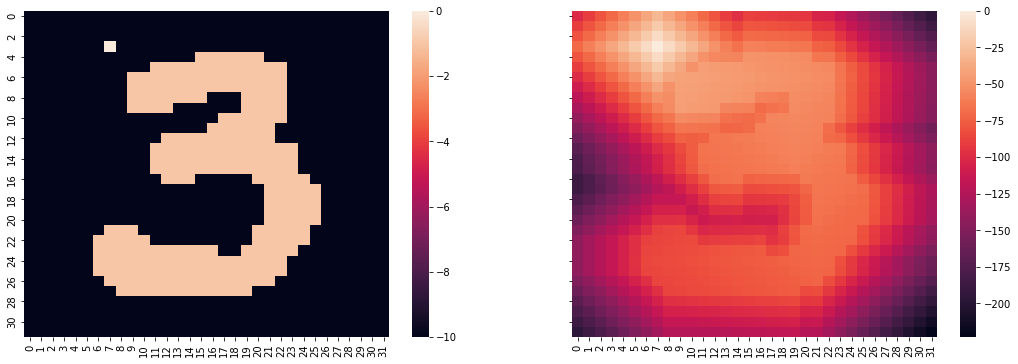

(32, 32) (32, 32)
3 7 = -98651.0
################################################################################
this is road
[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15)]
Calculating cost for (3, 15)


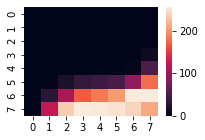

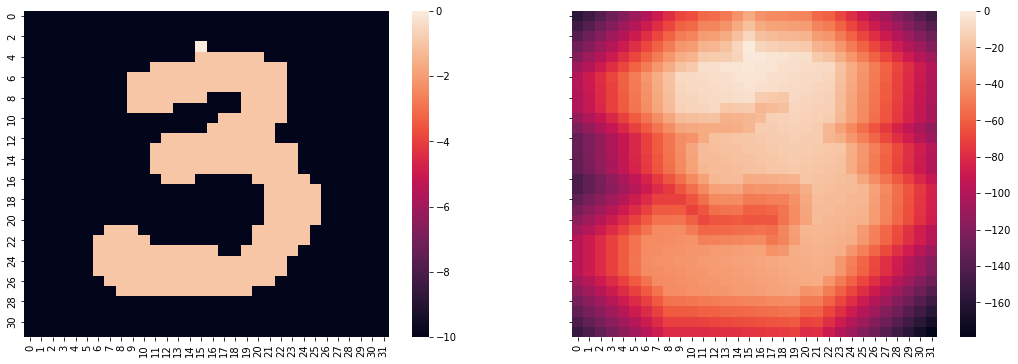

(32, 32) (32, 32)
3 15 = -60659.0
################################################################################
this is road
[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7)]
Calculating cost for (11, 7)


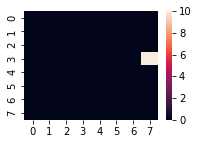

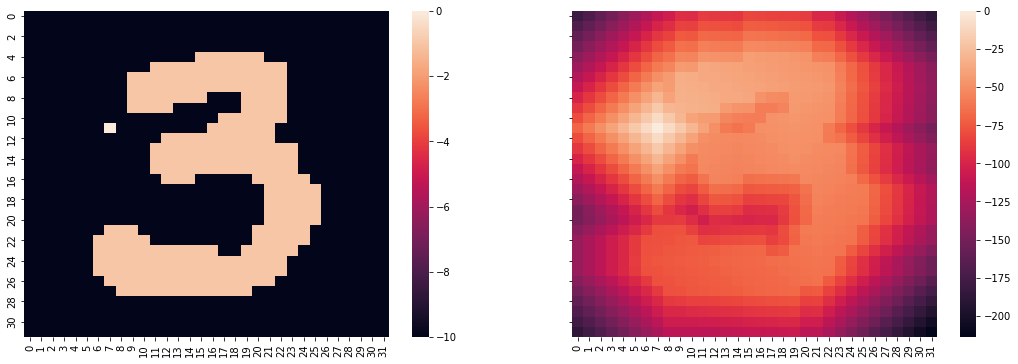

(32, 32) (32, 32)
11 7 = -89207.0
################################################################################
this is road
[(8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Calculating cost for (11, 15)


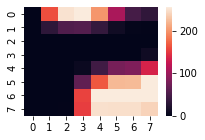

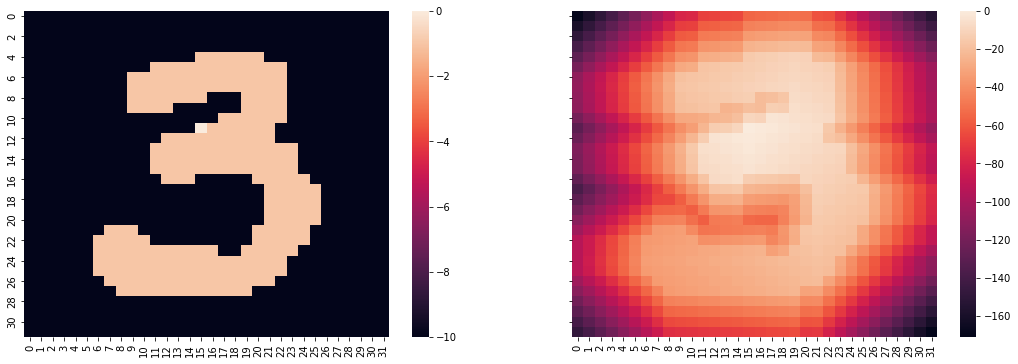

(32, 32) (32, 32)
11 15 = -57047.0
################################################################################
[(3, 7), (3, 15), (11, 7), (11, 15)]
++++++++++++++++++++++++++++++++++++++++
[-98651.0, -60659.0, -89207.0, -57047.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
11 15 : -57047.0


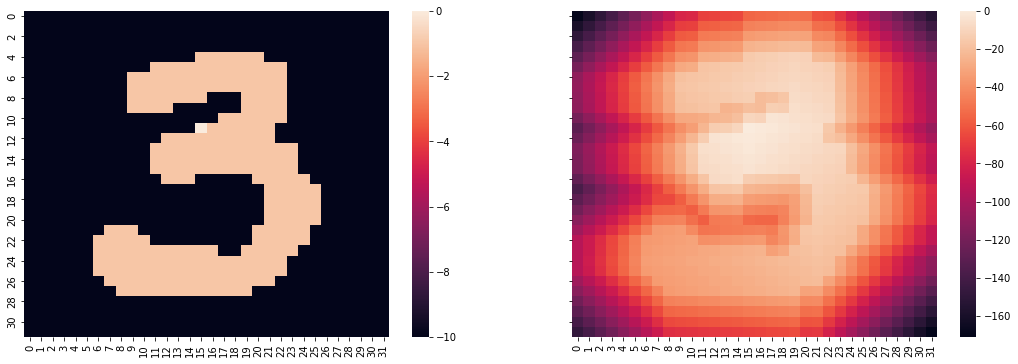

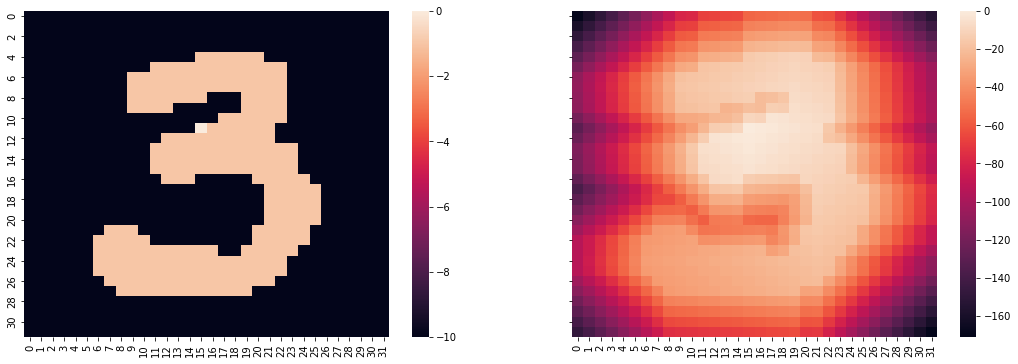

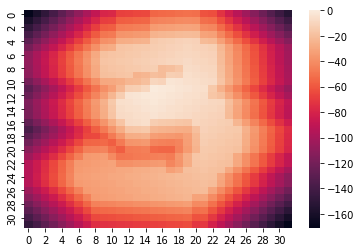

-169.0 -148.0 -153.0 -171.0 sum:  -641.0


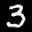

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

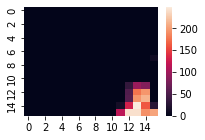

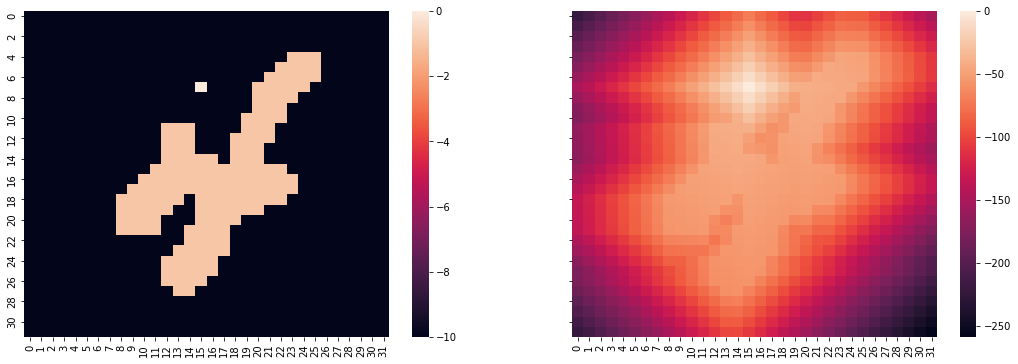

(32, 32) (32, 32)
7 15 = -104307.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16

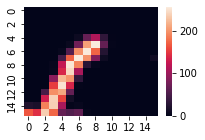

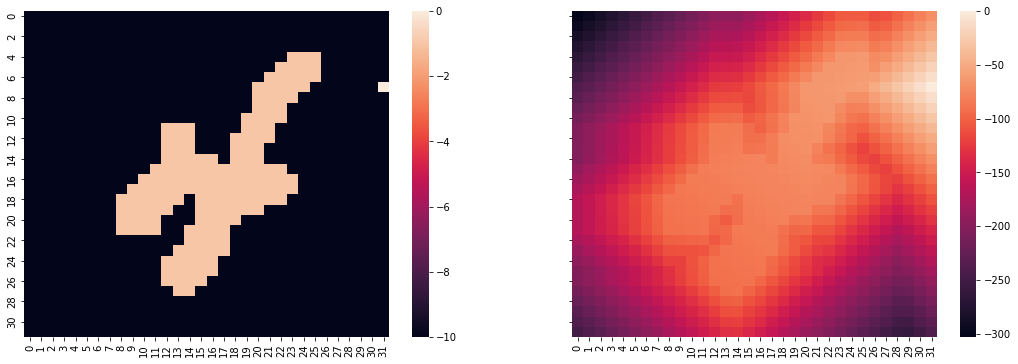

(32, 32) (32, 32)
7 31 = -136620.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), 

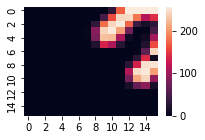

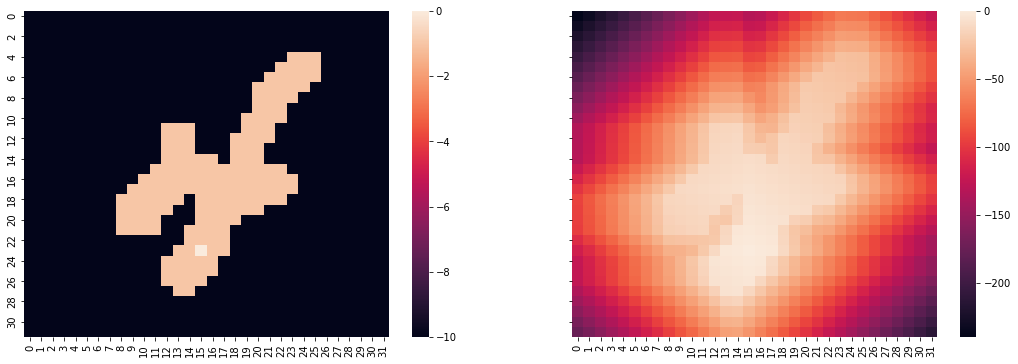

(32, 32) (32, 32)
23 15 = -75806.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

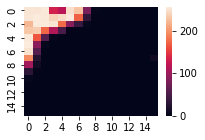

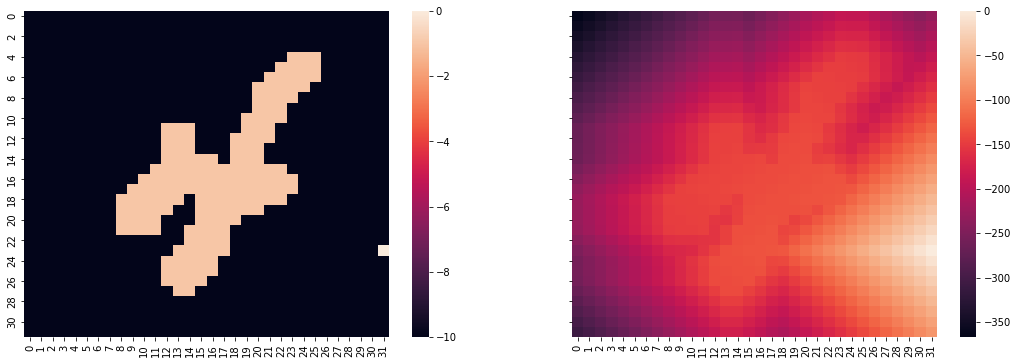

(32, 32) (32, 32)
23 31 = -179208.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-104307.0, -136620.0, -75806.0, -179208.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
23 15 : -75806.0


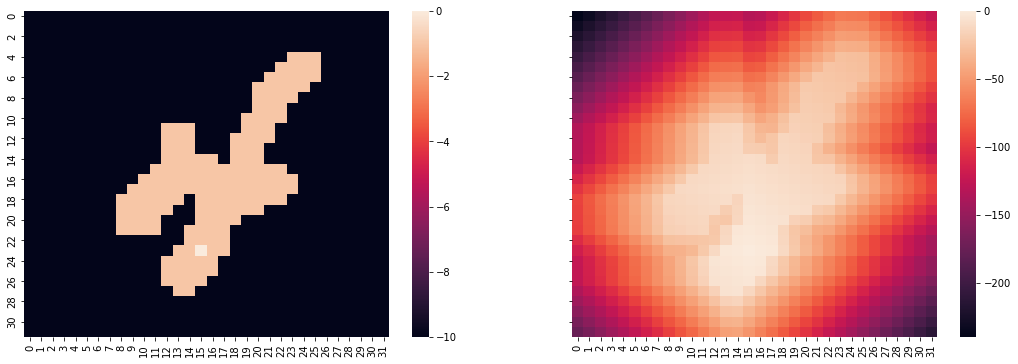

this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7)]
Calculating cost for (19, 7)


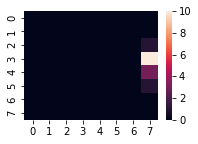

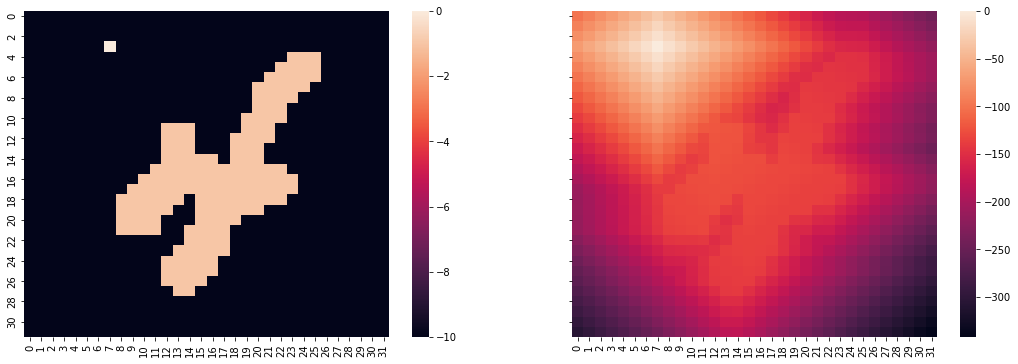

(32, 32) (32, 32)
19 7 = -165515.0
################################################################################
this is road
[(16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15)]
Calculating cost for (19, 15)


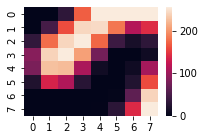

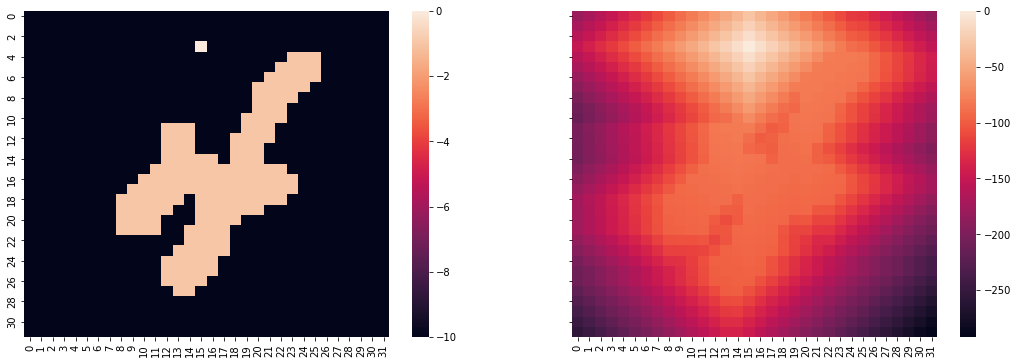

(32, 32) (32, 32)
19 15 = -134383.0
################################################################################
this is road
[(24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (27, 0), (27, 1), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (29, 0), (29, 1), (29, 2), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (31, 0), (31, 1), (31, 2), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7)]
Calculating cost for (27, 7)


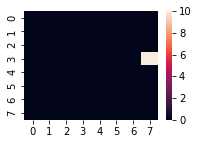

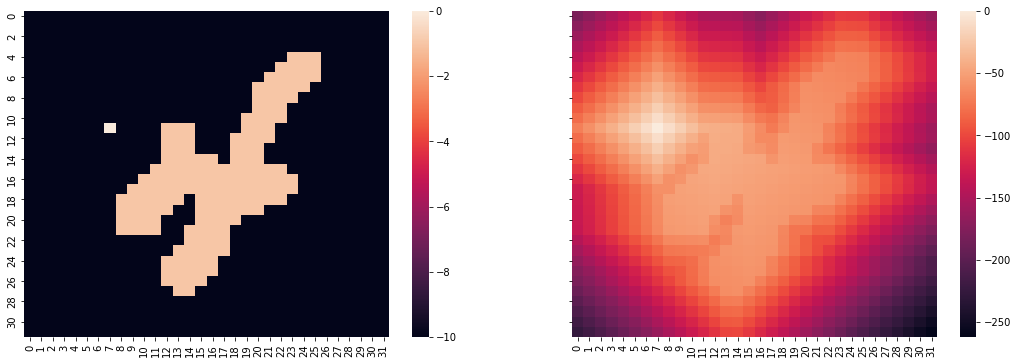

(32, 32) (32, 32)
27 7 = -104883.0
################################################################################
this is road
[(24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 8), (29, 9), (29, 10), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15)]
Calculating cost for (27, 15)


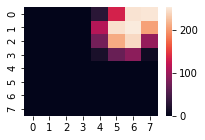

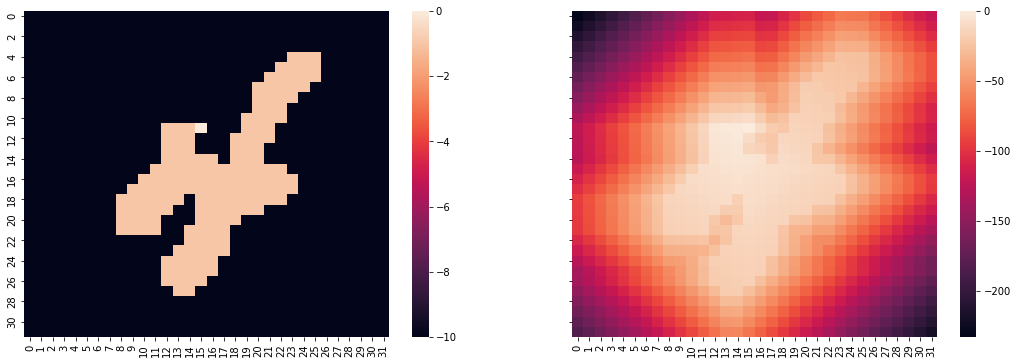

(32, 32) (32, 32)
27 15 = -76431.0
################################################################################
[(19, 7), (19, 15), (27, 7), (27, 15)]
++++++++++++++++++++++++++++++++++++++++
[-165515.0, -134383.0, -104883.0, -76431.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
27 15 : -76431.0


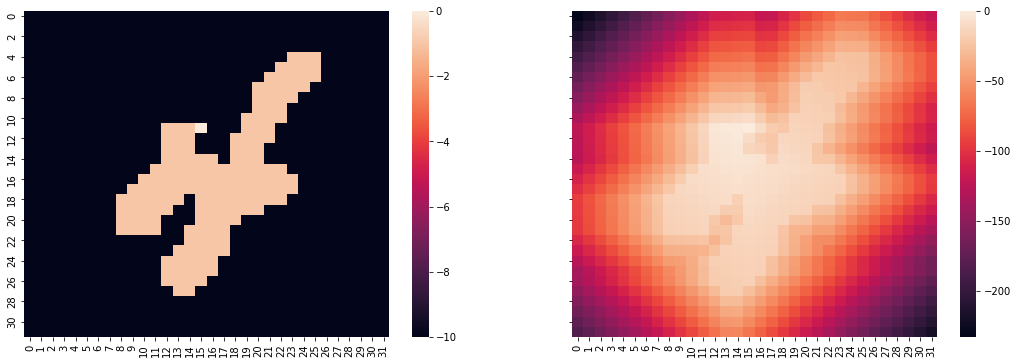

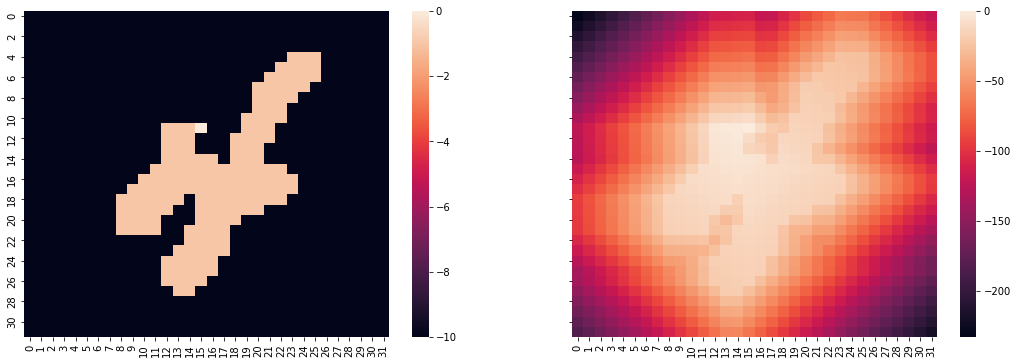

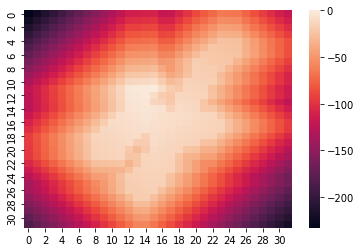

-233.0 -184.0 -121.0 -220.0 sum:  -758.0


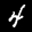

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

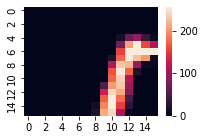

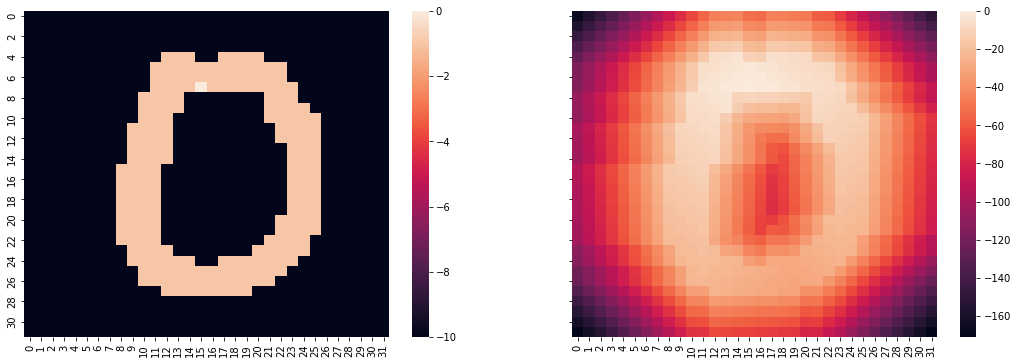

(32, 32) (32, 32)
7 15 = -56579.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

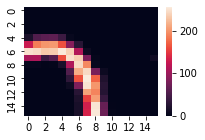

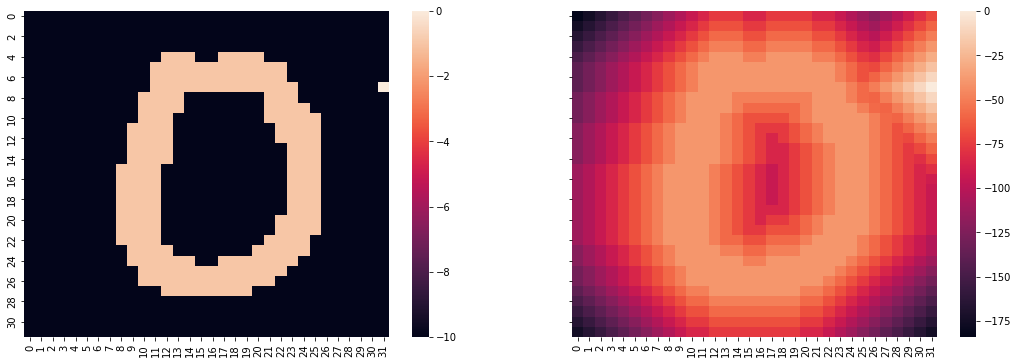

(32, 32) (32, 32)
7 31 = -73962.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (

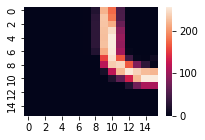

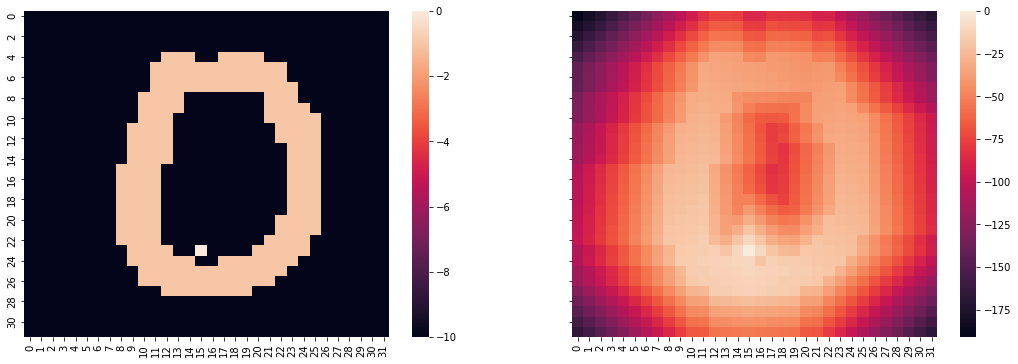

(32, 32) (32, 32)
23 15 = -67212.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

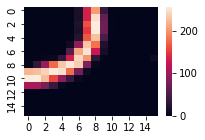

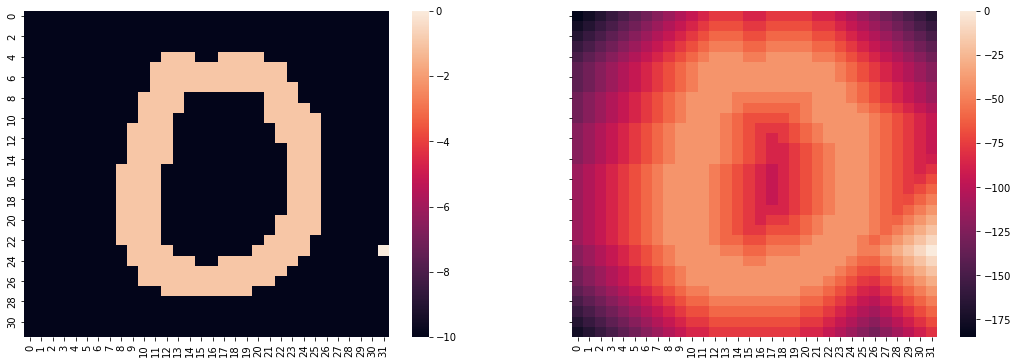

(32, 32) (32, 32)
23 31 = -74825.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-56579.0, -73962.0, -67212.0, -74825.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
7 15 : -56579.0


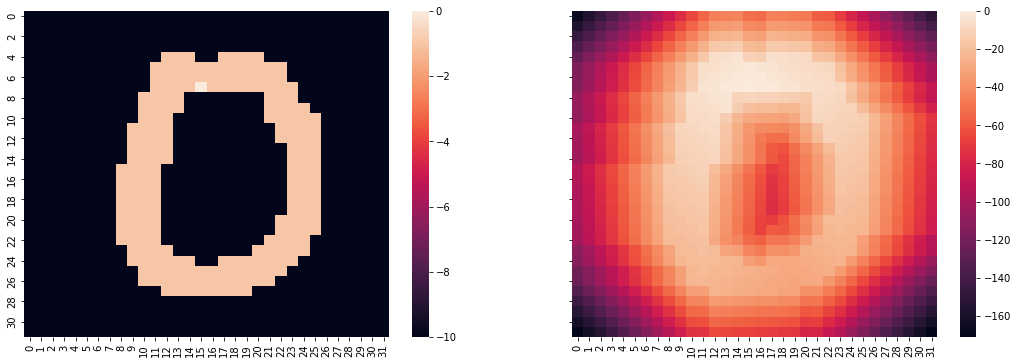

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Calculating cost for (3, 7)


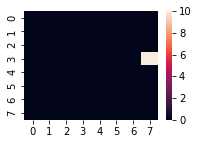

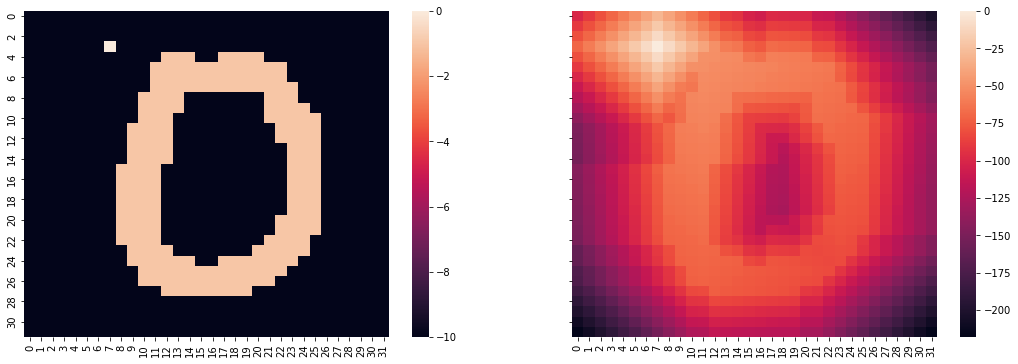

(32, 32) (32, 32)
3 7 = -101313.0
################################################################################
this is road
[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15)]
Calculating cost for (3, 15)


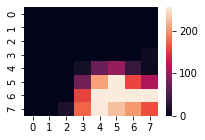

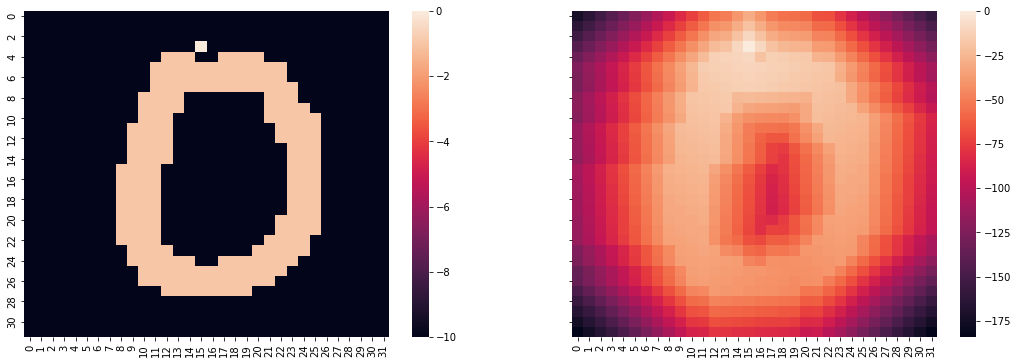

(32, 32) (32, 32)
3 15 = -68616.0
################################################################################
this is road
[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7)]
Calculating cost for (11, 7)


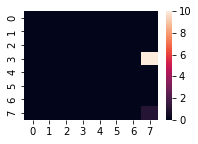

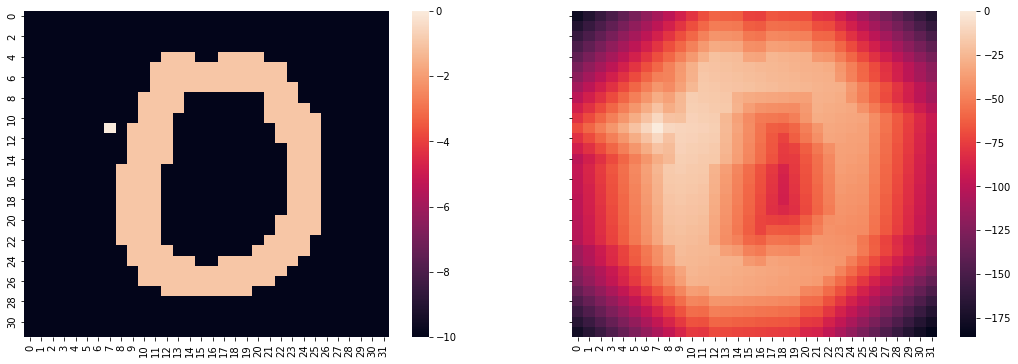

(32, 32) (32, 32)
11 7 = -67253.0
################################################################################
this is road
[(8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Calculating cost for (11, 15)


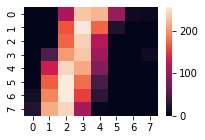

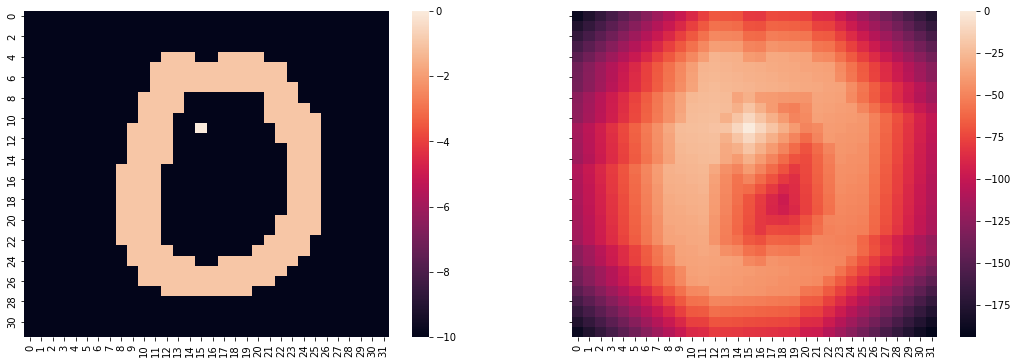

(32, 32) (32, 32)
11 15 = -76685.0
################################################################################
[(3, 7), (3, 15), (11, 7), (11, 15)]
++++++++++++++++++++++++++++++++++++++++
[-101313.0, -68616.0, -67253.0, -76685.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
11 7 : -67253.0


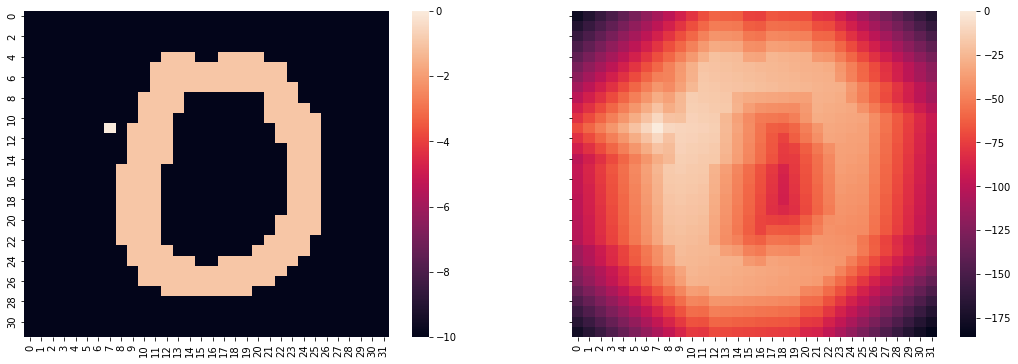

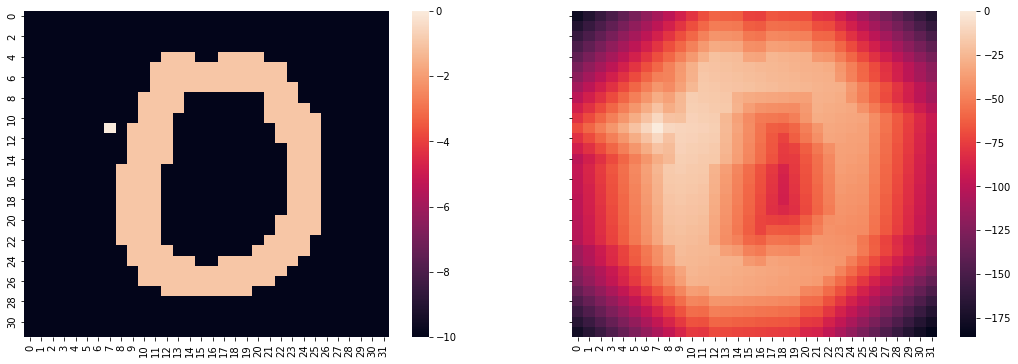

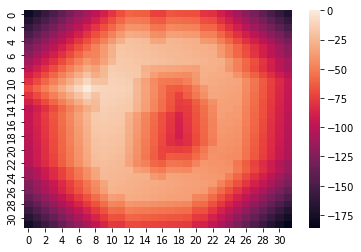

-179.0 -177.0 -170.0 -186.0 sum:  -712.0


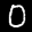

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

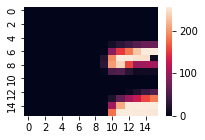

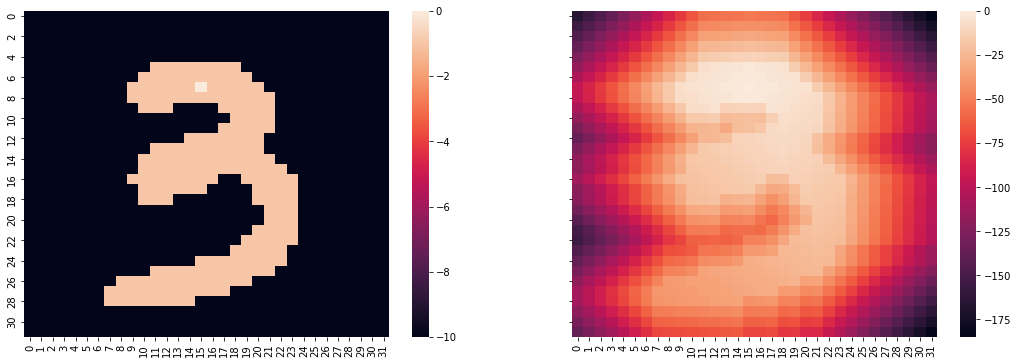

(32, 32) (32, 32)
7 15 = -64683.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

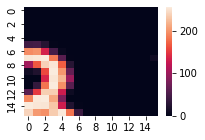

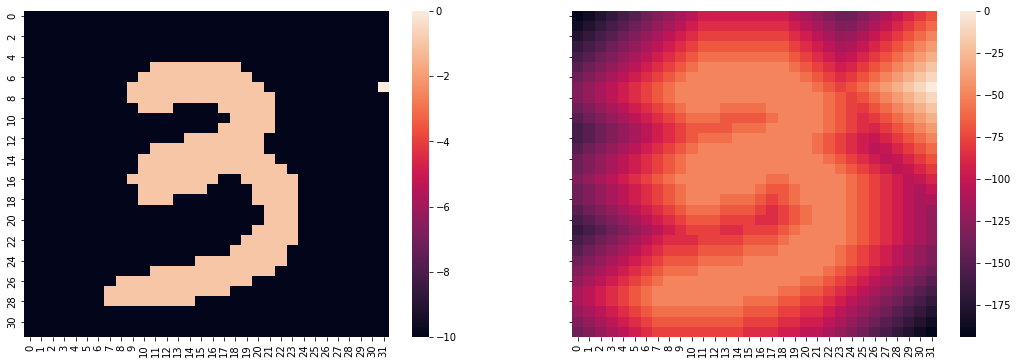

(32, 32) (32, 32)
7 31 = -86009.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (

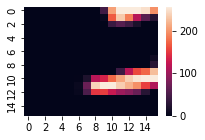

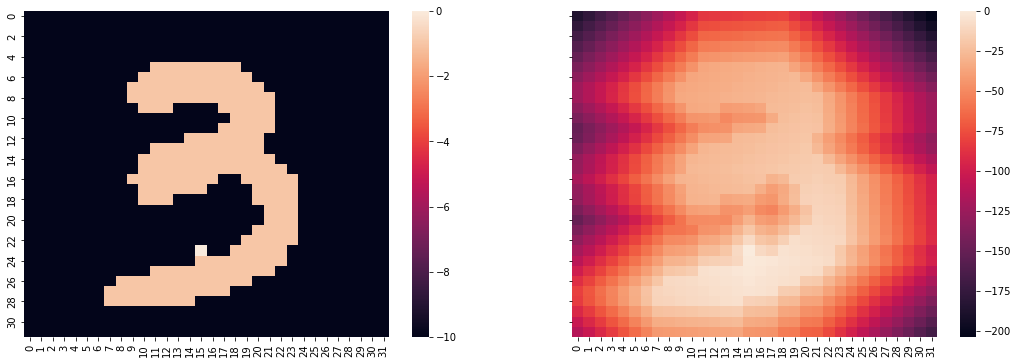

(32, 32) (32, 32)
23 15 = -67576.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

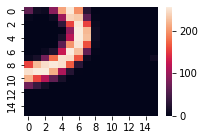

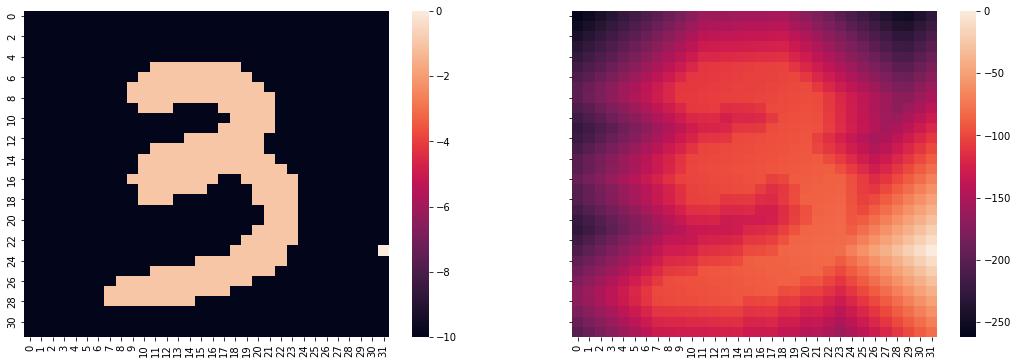

(32, 32) (32, 32)
23 31 = -133852.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-64683.0, -86009.0, -67576.0, -133852.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
7 15 : -64683.0


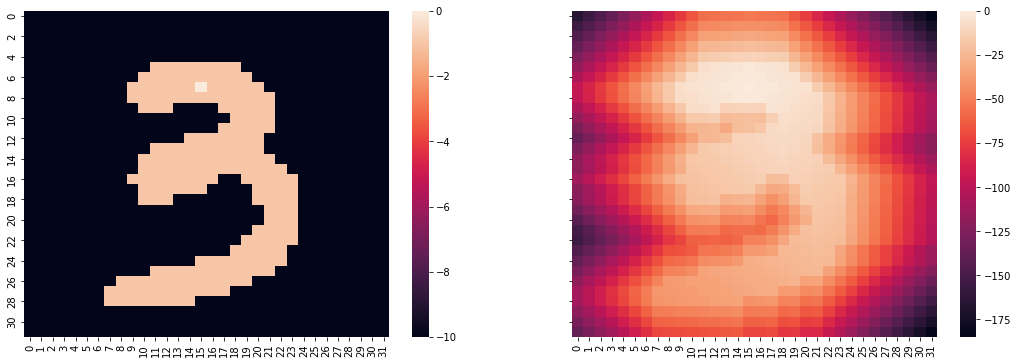

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Calculating cost for (3, 7)


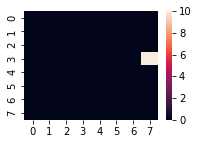

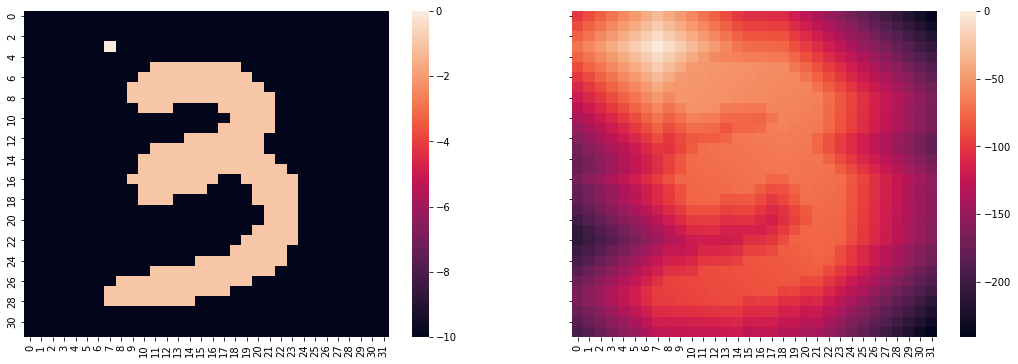

(32, 32) (32, 32)
3 7 = -112633.0
################################################################################
this is road
[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15)]
Calculating cost for (3, 15)


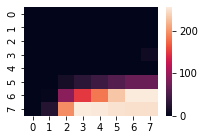

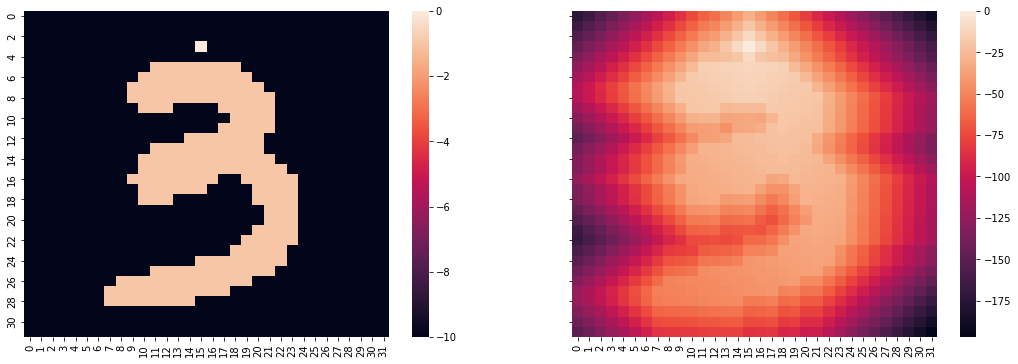

(32, 32) (32, 32)
3 15 = -76504.0
################################################################################
this is road
[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7)]
Calculating cost for (11, 7)


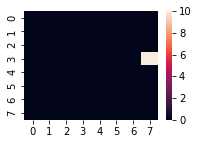

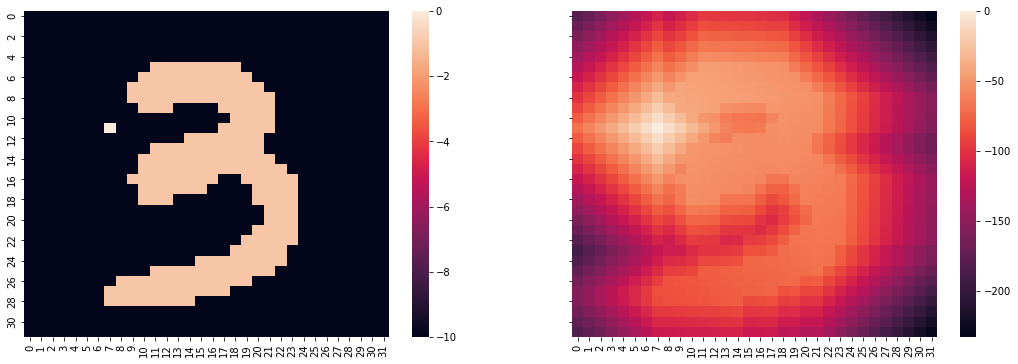

(32, 32) (32, 32)
11 7 = -101498.0
################################################################################
this is road
[(8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Calculating cost for (11, 15)


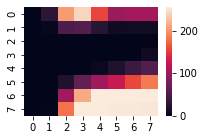

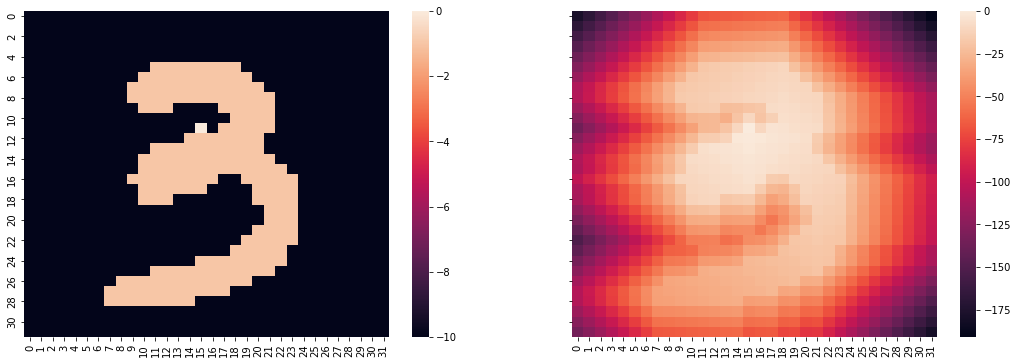

(32, 32) (32, 32)
11 15 = -64010.0
################################################################################
[(3, 7), (3, 15), (11, 7), (11, 15)]
++++++++++++++++++++++++++++++++++++++++
[-112633.0, -76504.0, -101498.0, -64010.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
11 15 : -64010.0


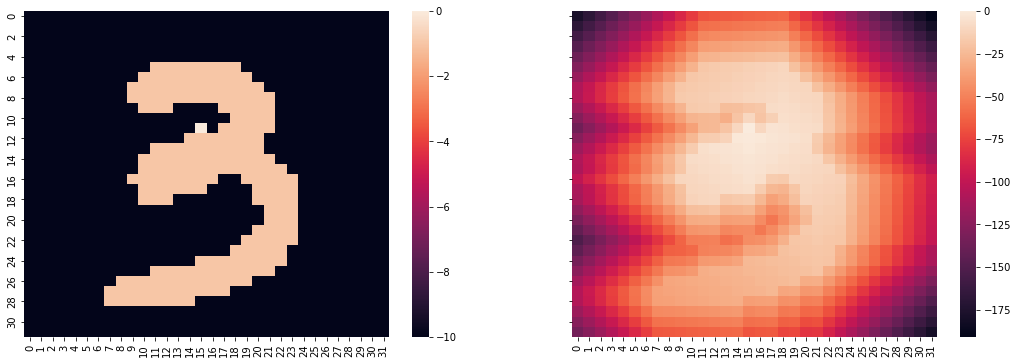

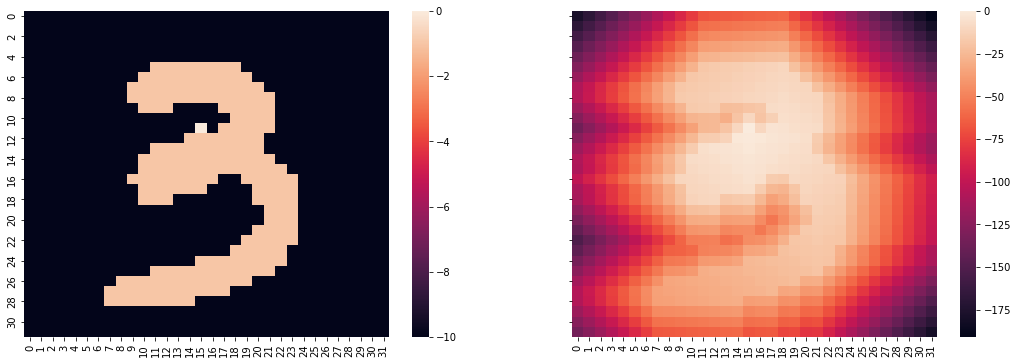

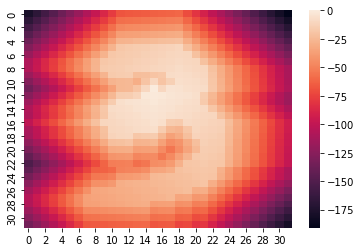

-178.0 -135.0 -191.0 -180.0 sum:  -684.0


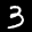

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

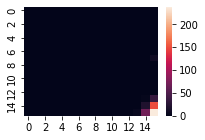

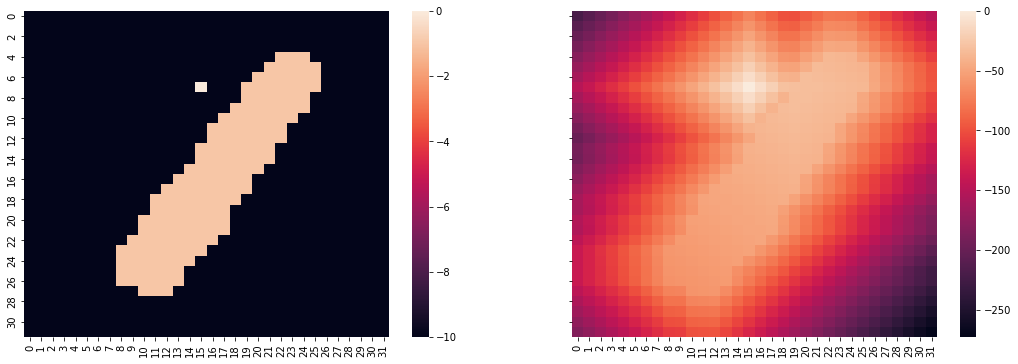

(32, 32) (32, 32)
7 15 = -105482.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16

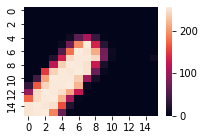

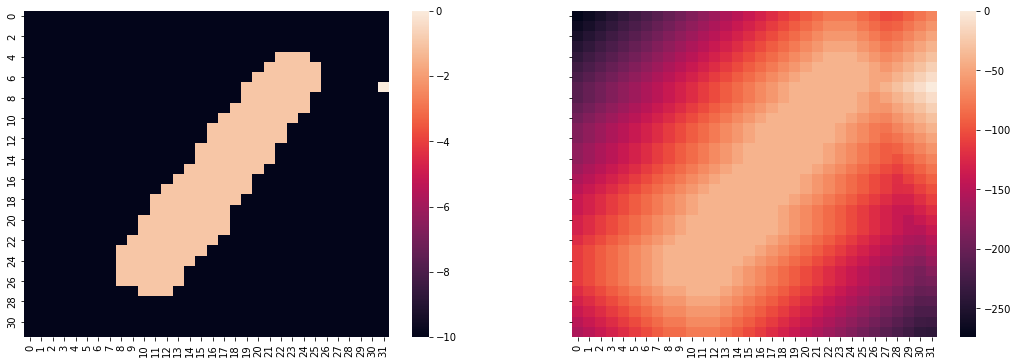

(32, 32) (32, 32)
7 31 = -103163.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), 

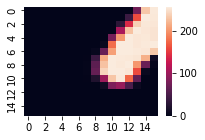

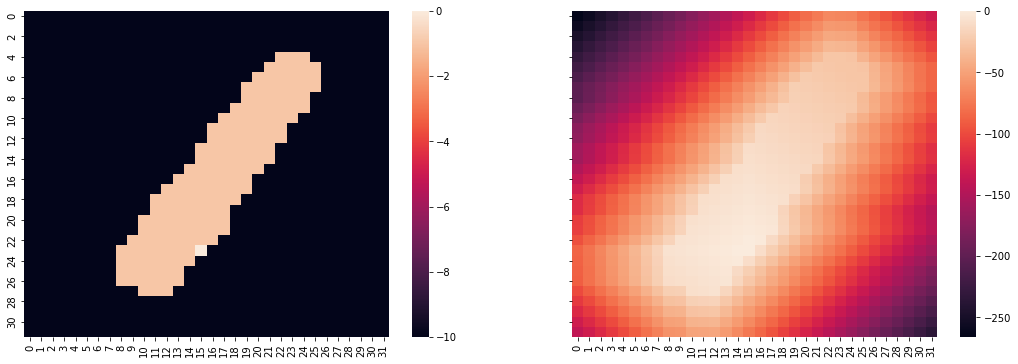

(32, 32) (32, 32)
23 15 = -85145.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

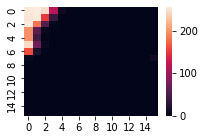

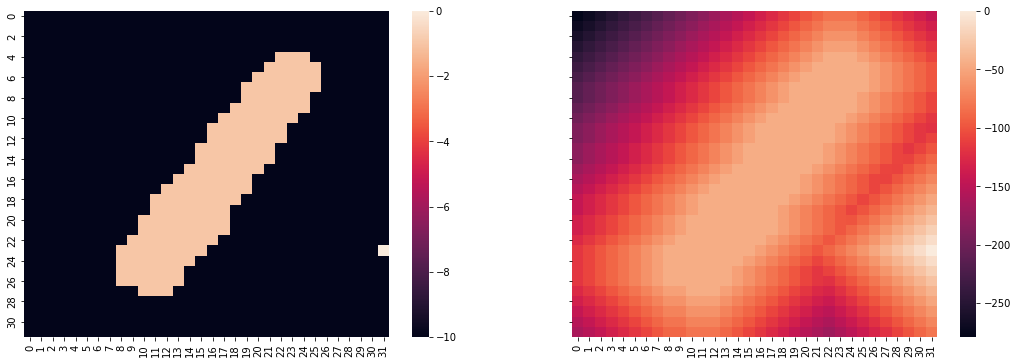

(32, 32) (32, 32)
23 31 = -99738.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-105482.0, -103163.0, -85145.0, -99738.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
23 15 : -85145.0


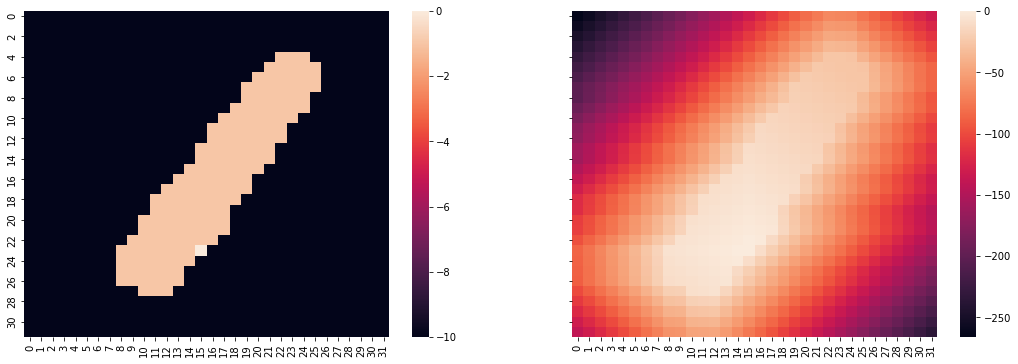

this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7)]
Calculating cost for (19, 7)


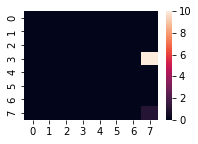

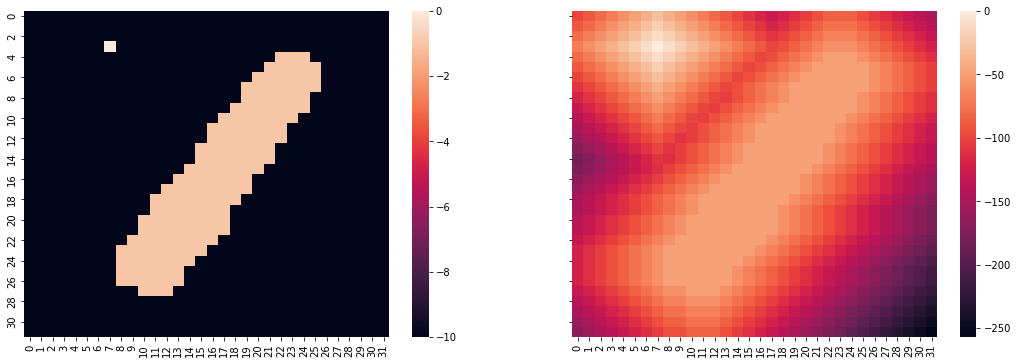

(32, 32) (32, 32)
19 7 = -97387.0
################################################################################
this is road
[(16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15)]
Calculating cost for (19, 15)


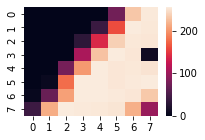

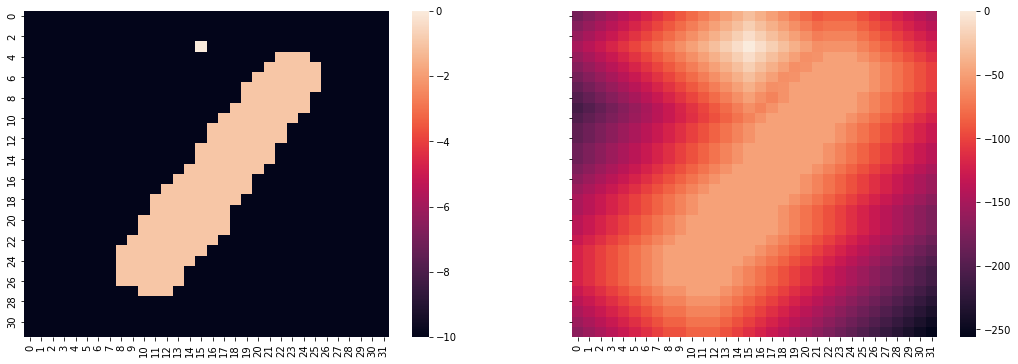

(32, 32) (32, 32)
19 15 = -102331.0
################################################################################
this is road
[(24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (27, 0), (27, 1), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (29, 0), (29, 1), (29, 2), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (31, 0), (31, 1), (31, 2), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7)]
Calculating cost for (27, 7)


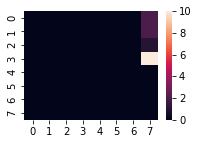

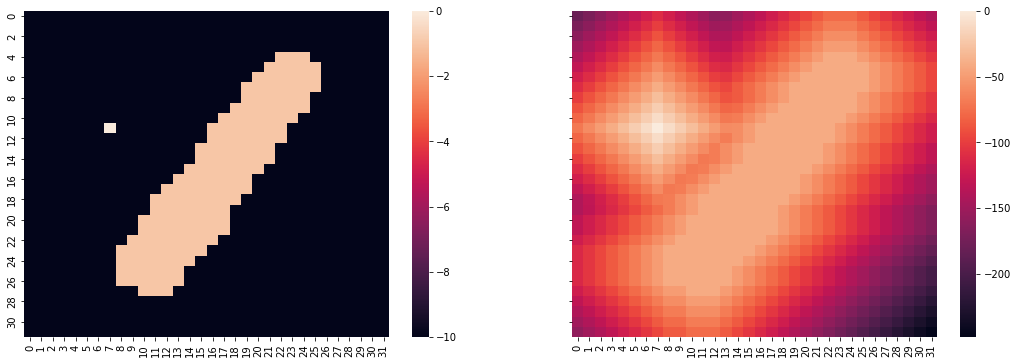

(32, 32) (32, 32)
27 7 = -90404.0
################################################################################
this is road
[(24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 8), (29, 9), (29, 10), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15)]
Calculating cost for (27, 15)


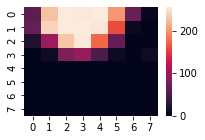

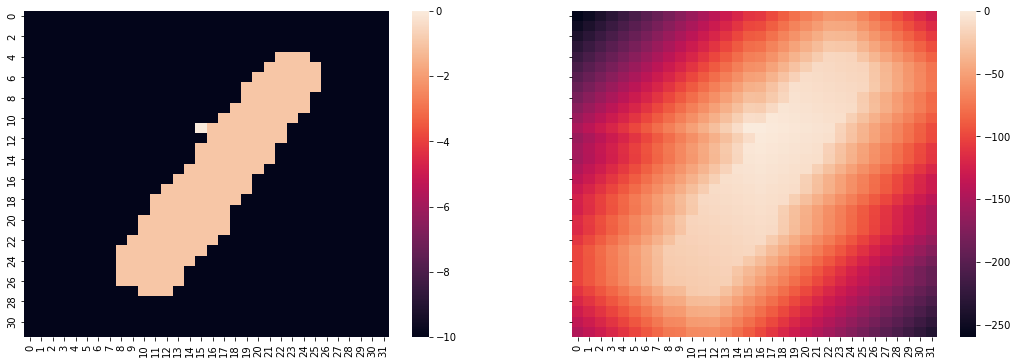

(32, 32) (32, 32)
27 15 = -83161.0
################################################################################
[(19, 7), (19, 15), (27, 7), (27, 15)]
++++++++++++++++++++++++++++++++++++++++
[-97387.0, -102331.0, -90404.0, -83161.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
27 15 : -83161.0


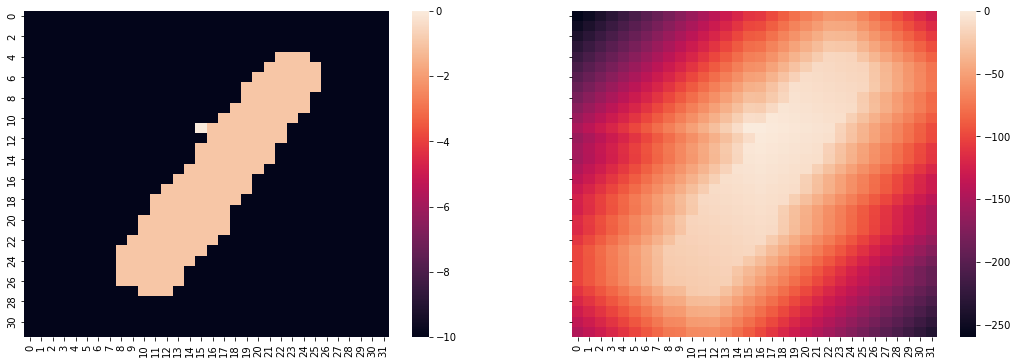

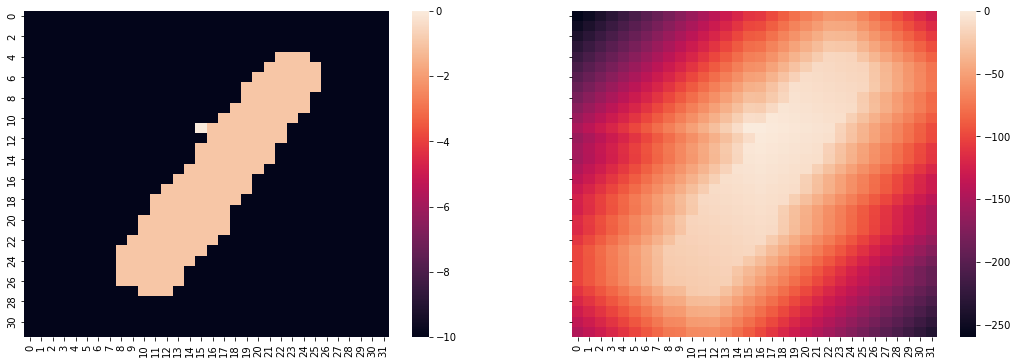

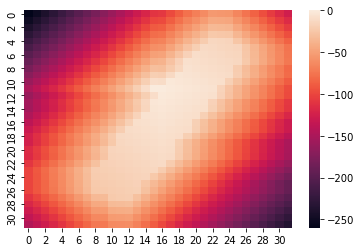

-260.0 -146.0 -126.0 -236.0 sum:  -768.0


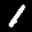

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

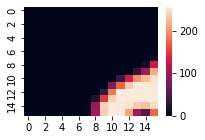

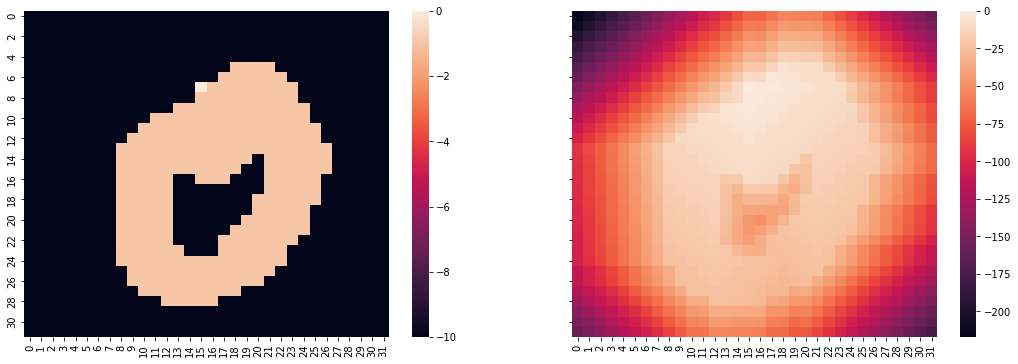

(32, 32) (32, 32)
7 15 = -59809.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

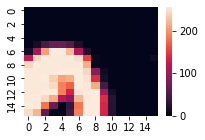

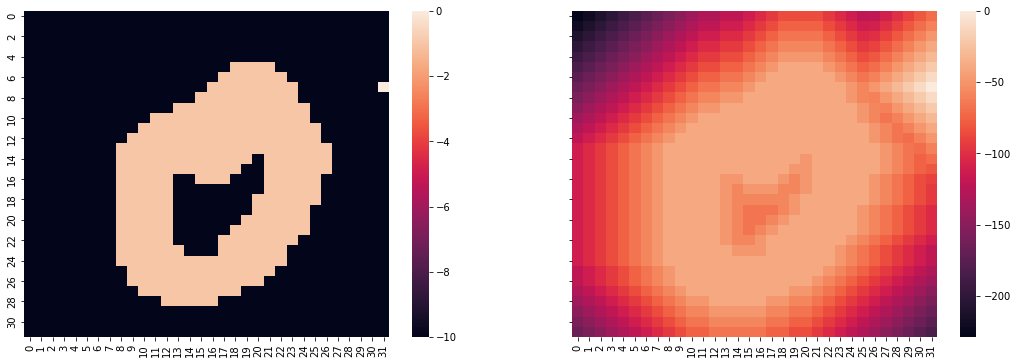

(32, 32) (32, 32)
7 31 = -77378.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (

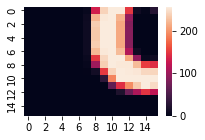

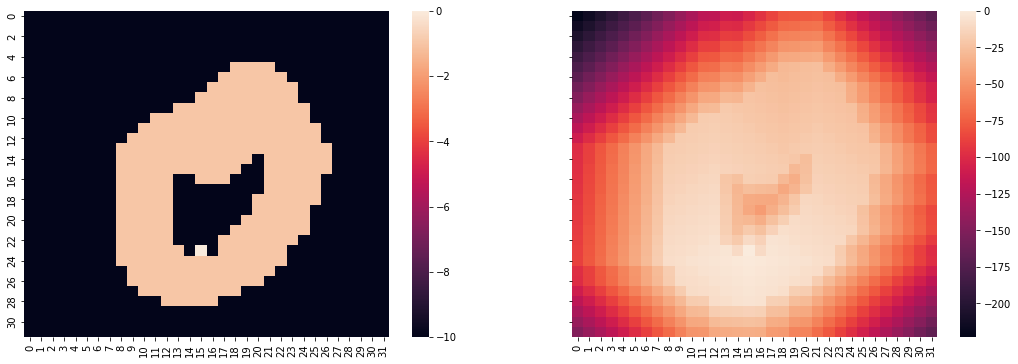

(32, 32) (32, 32)
23 15 = -60605.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

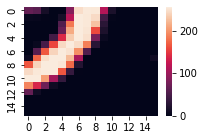

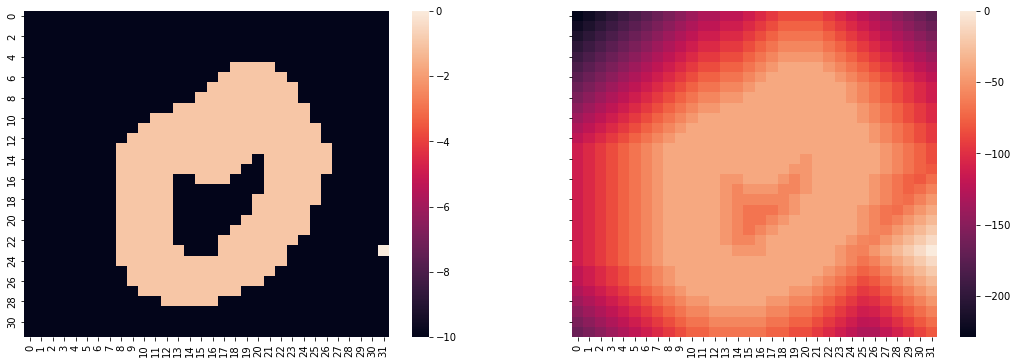

(32, 32) (32, 32)
23 31 = -76917.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-59809.0, -77378.0, -60605.0, -76917.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
7 15 : -59809.0


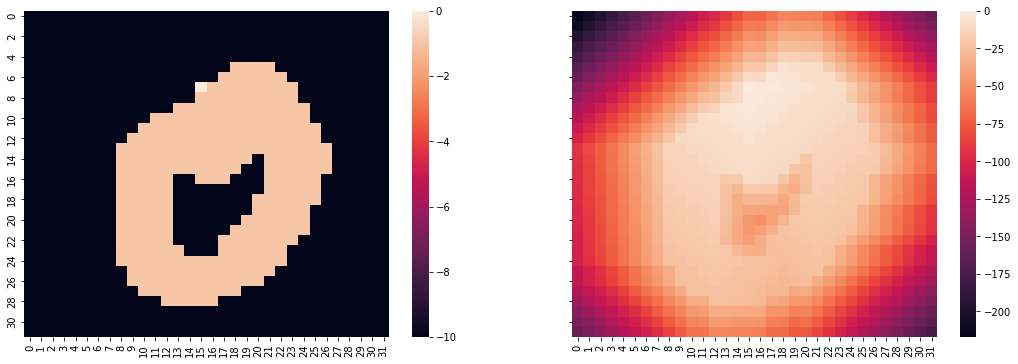

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Calculating cost for (3, 7)


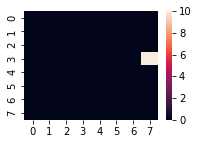

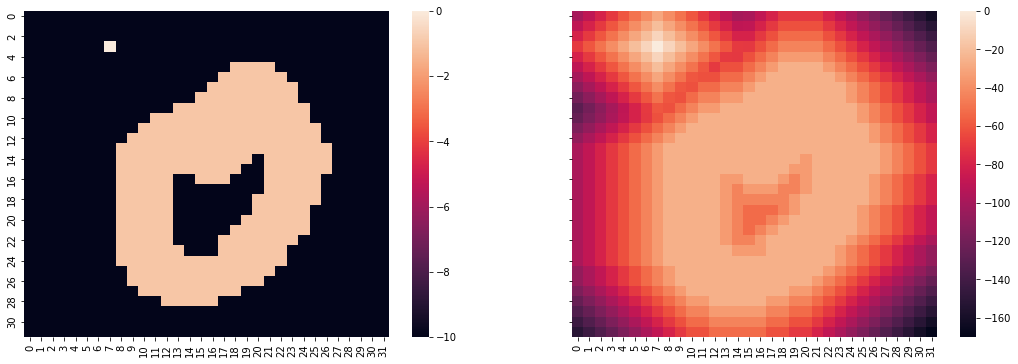

(32, 32) (32, 32)
3 7 = -58425.0
################################################################################
this is road
[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15)]
Calculating cost for (3, 15)


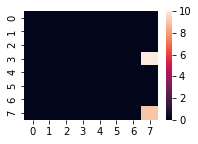

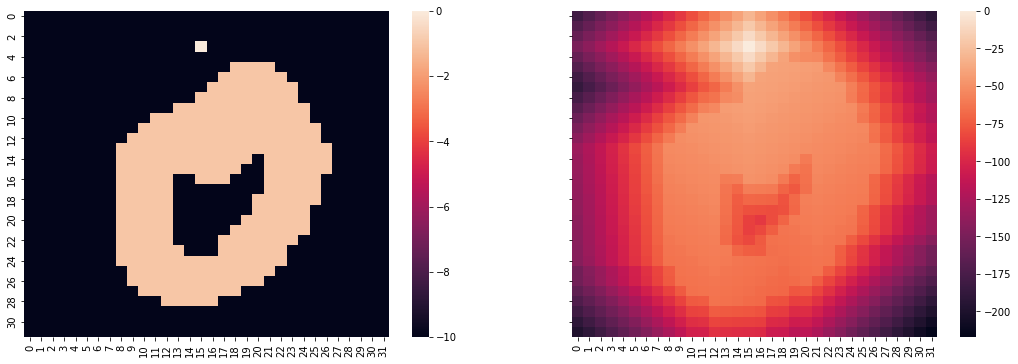

(32, 32) (32, 32)
3 15 = -92592.0
################################################################################
this is road
[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7)]
Calculating cost for (11, 7)


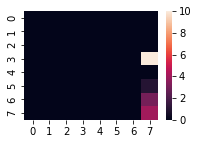

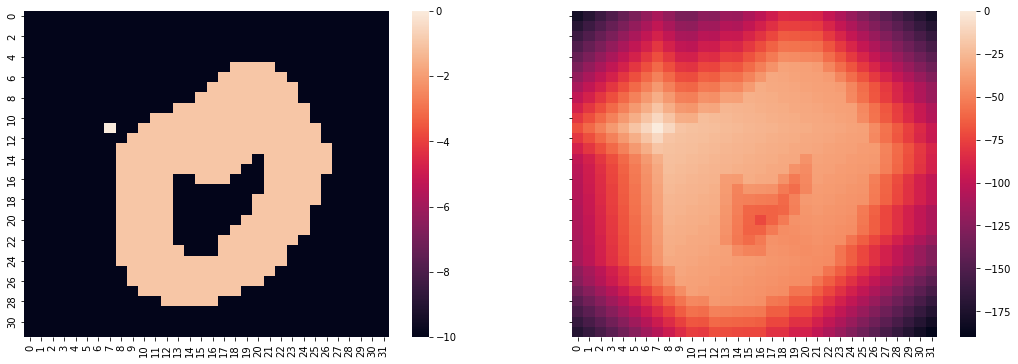

(32, 32) (32, 32)
11 7 = -72617.0
################################################################################
this is road
[(8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Calculating cost for (11, 15)


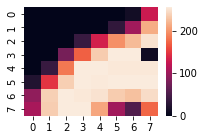

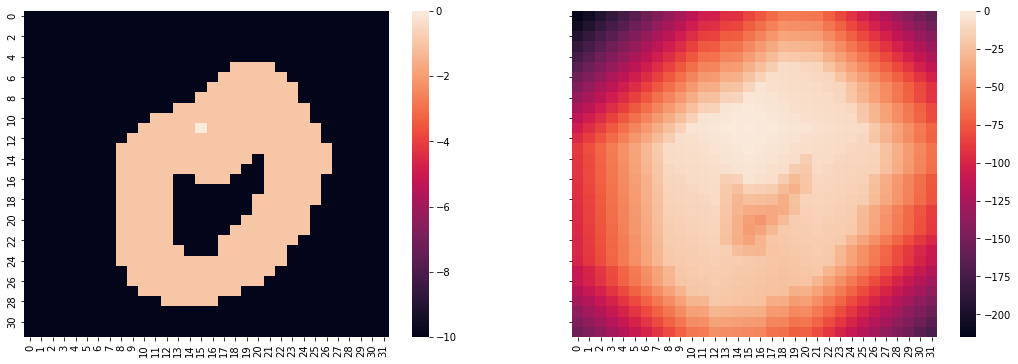

(32, 32) (32, 32)
11 15 = -57702.0
################################################################################
[(3, 7), (3, 15), (11, 7), (11, 15)]
++++++++++++++++++++++++++++++++++++++++
[-58425.0, -92592.0, -72617.0, -57702.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
11 15 : -57702.0


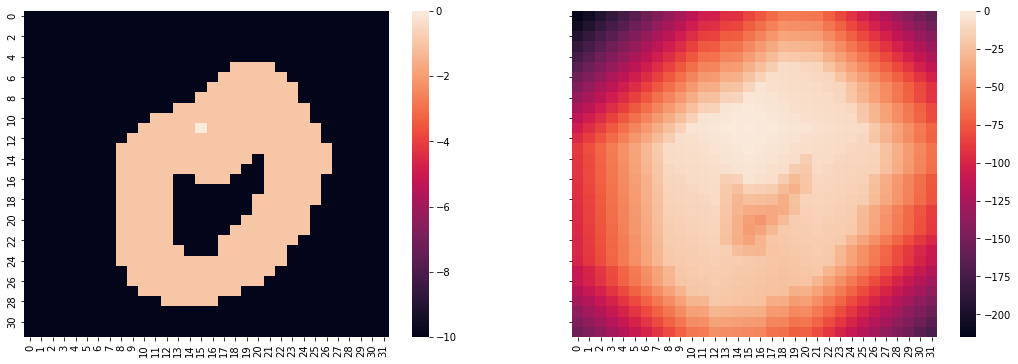

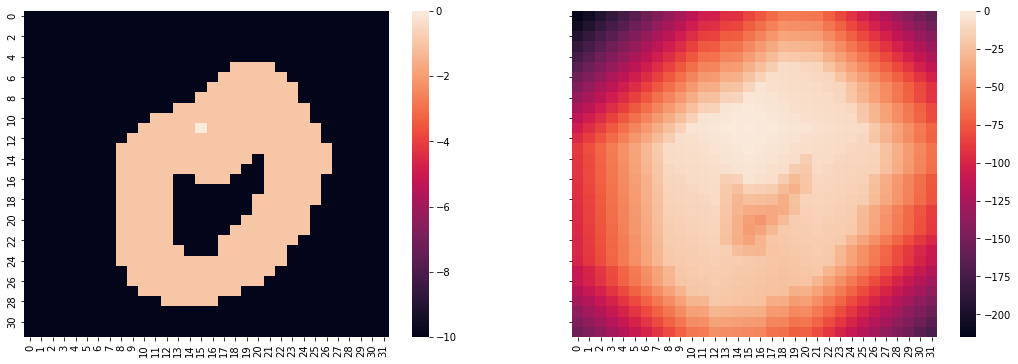

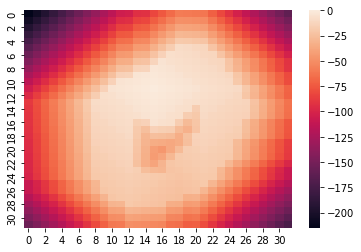

-215.0 -155.0 -162.0 -173.0 sum:  -705.0


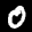

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

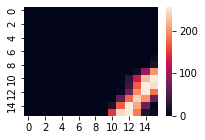

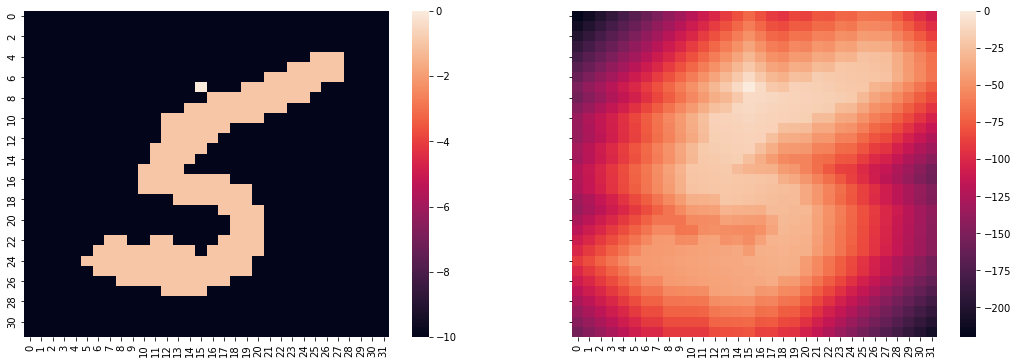

(32, 32) (32, 32)
7 15 = -77928.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

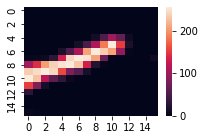

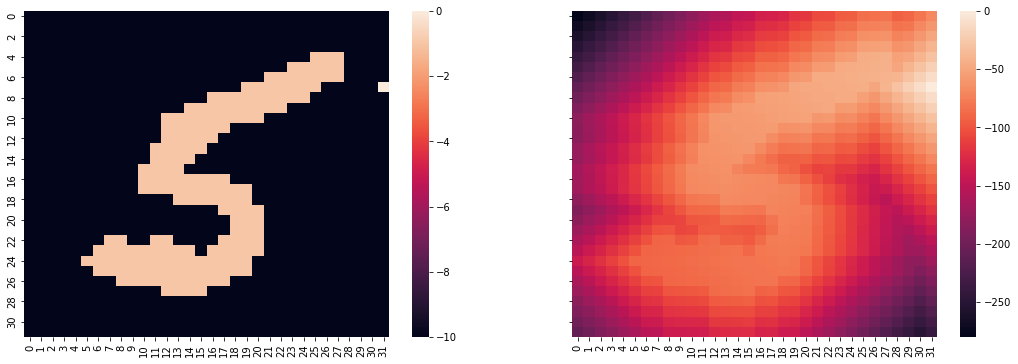

(32, 32) (32, 32)
7 31 = -117741.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), 

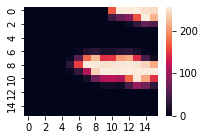

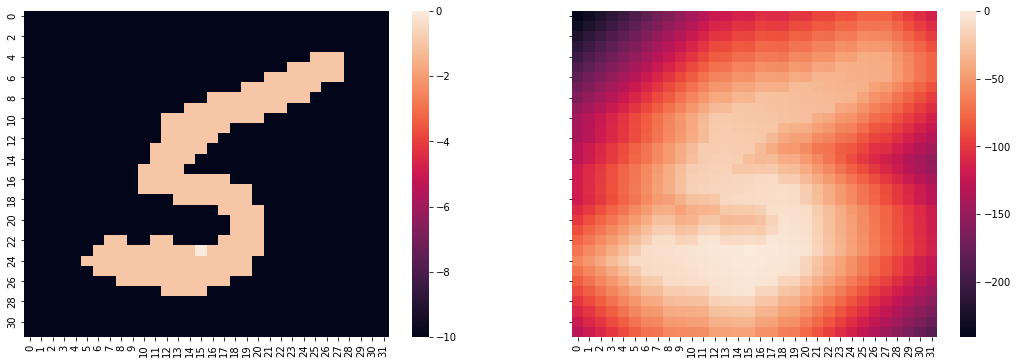

(32, 32) (32, 32)
23 15 = -71078.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

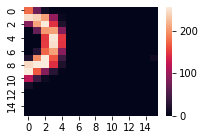

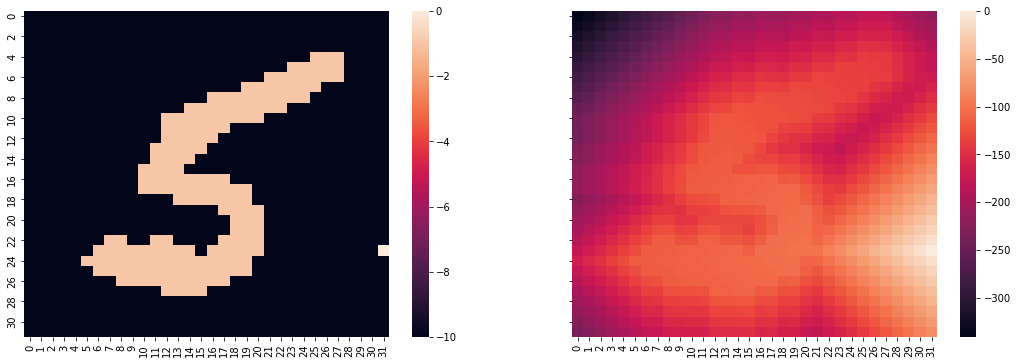

(32, 32) (32, 32)
23 31 = -153984.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-77928.0, -117741.0, -71078.0, -153984.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
23 15 : -71078.0


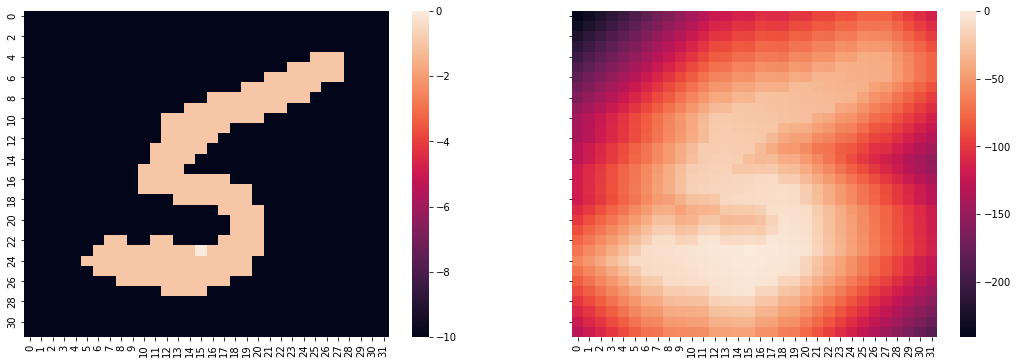

this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (22, 0), (22, 1), (22, 2), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (23, 0), (23, 1), (23, 2), (23, 3), (23, 4), (23, 5), (23, 6), (23, 7)]
Calculating cost for (19, 7)


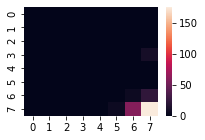

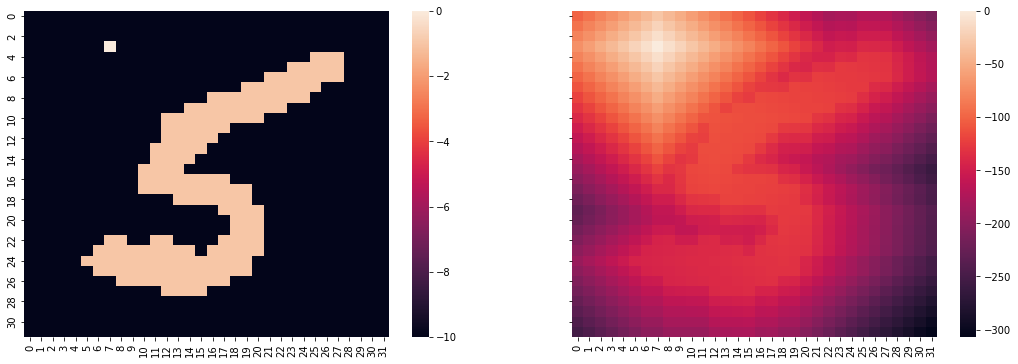

(32, 32) (32, 32)
19 7 = -153251.99999999997
################################################################################
this is road
[(16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (22, 14), (22, 15), (23, 8), (23, 9), (23, 10), (23, 11), (23, 12), (23, 13), (23, 14), (23, 15)]
Calculating cost for (19, 15)


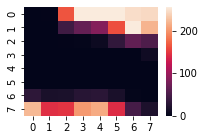

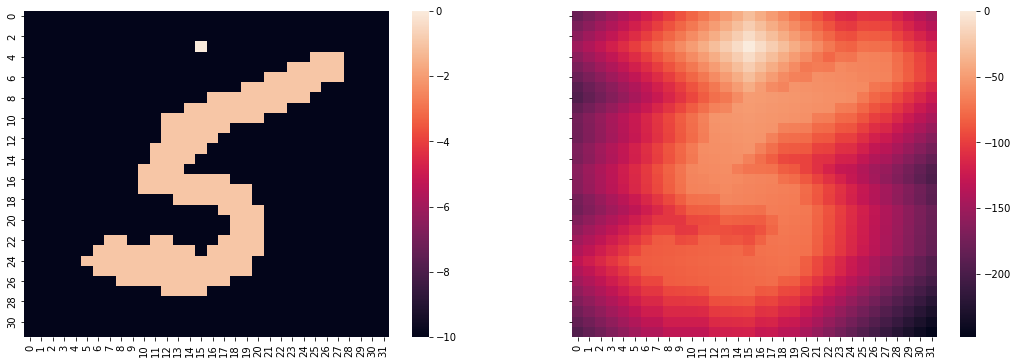

(32, 32) (32, 32)
19 15 = -109891.0
################################################################################
this is road
[(24, 0), (24, 1), (24, 2), (24, 3), (24, 4), (24, 5), (24, 6), (24, 7), (25, 0), (25, 1), (25, 2), (25, 3), (25, 4), (25, 5), (25, 6), (25, 7), (26, 0), (26, 1), (26, 2), (26, 3), (26, 4), (26, 5), (26, 6), (26, 7), (27, 0), (27, 1), (27, 2), (27, 3), (27, 4), (27, 5), (27, 6), (27, 7), (28, 0), (28, 1), (28, 2), (28, 3), (28, 4), (28, 5), (28, 6), (28, 7), (29, 0), (29, 1), (29, 2), (29, 3), (29, 4), (29, 5), (29, 6), (29, 7), (30, 0), (30, 1), (30, 2), (30, 3), (30, 4), (30, 5), (30, 6), (30, 7), (31, 0), (31, 1), (31, 2), (31, 3), (31, 4), (31, 5), (31, 6), (31, 7)]
Calculating cost for (27, 7)


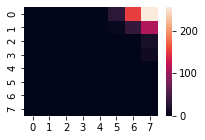

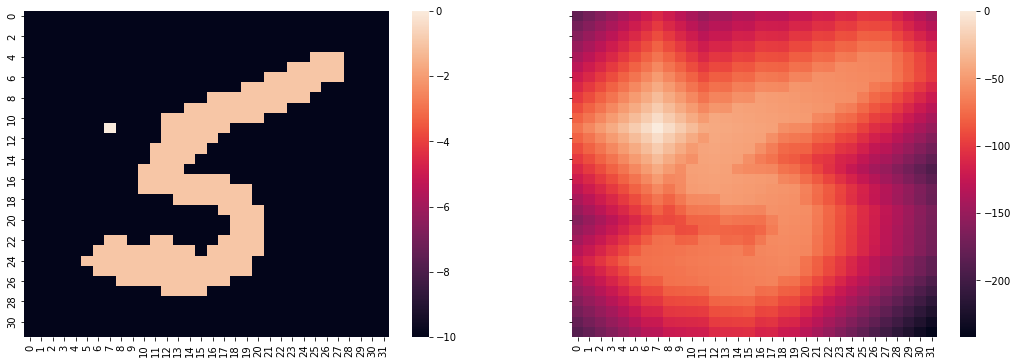

(32, 32) (32, 32)
27 7 = -98271.0
################################################################################
this is road
[(24, 8), (24, 9), (24, 10), (24, 11), (24, 12), (24, 13), (24, 14), (24, 15), (25, 8), (25, 9), (25, 10), (25, 11), (25, 12), (25, 13), (25, 14), (25, 15), (26, 8), (26, 9), (26, 10), (26, 11), (26, 12), (26, 13), (26, 14), (26, 15), (27, 8), (27, 9), (27, 10), (27, 11), (27, 12), (27, 13), (27, 14), (27, 15), (28, 8), (28, 9), (28, 10), (28, 11), (28, 12), (28, 13), (28, 14), (28, 15), (29, 8), (29, 9), (29, 10), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15), (30, 8), (30, 9), (30, 10), (30, 11), (30, 12), (30, 13), (30, 14), (30, 15), (31, 8), (31, 9), (31, 10), (31, 11), (31, 12), (31, 13), (31, 14), (31, 15)]
Calculating cost for (27, 15)


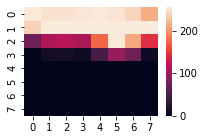

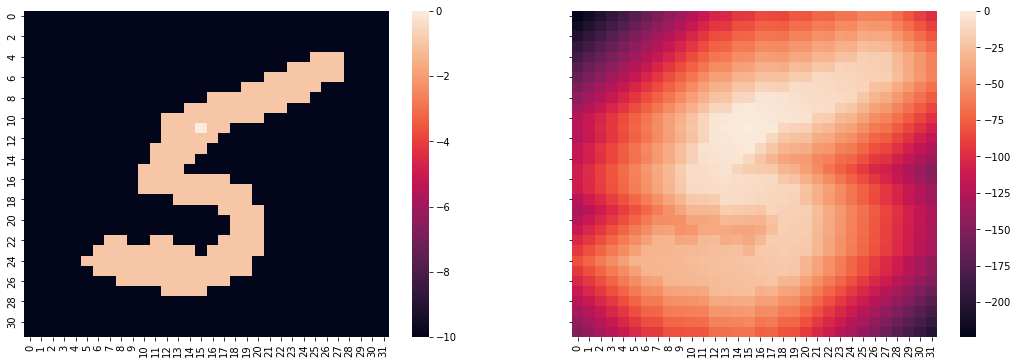

(32, 32) (32, 32)
27 15 = -69198.0
################################################################################
[(19, 7), (19, 15), (27, 7), (27, 15)]
++++++++++++++++++++++++++++++++++++++++
[-153251.99999999997, -109891.0, -98271.0, -69198.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
27 15 : -69198.0


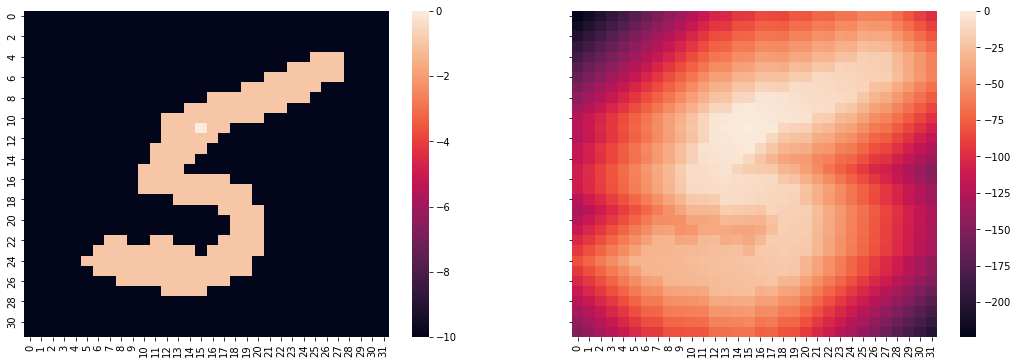

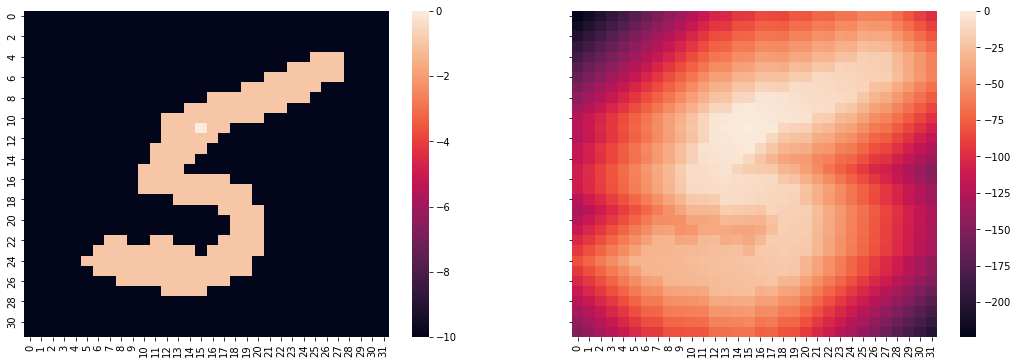

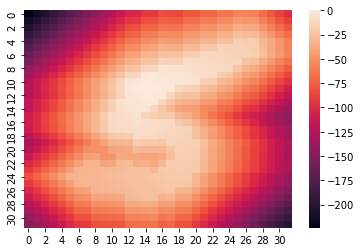

-224.0 -150.0 -99.0 -202.0 sum:  -675.0


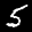

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), 

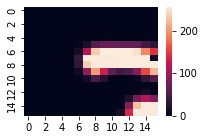

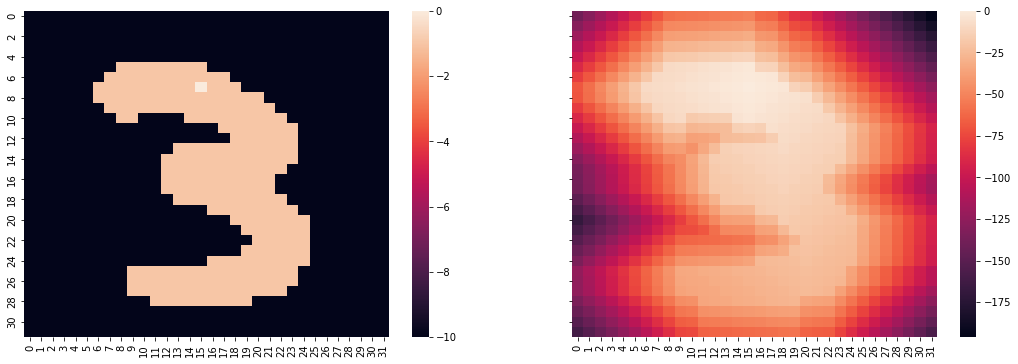

(32, 32) (32, 32)
7 15 = -61651.0
################################################################################
this is road
[(0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 29), (3, 30), (3, 31), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (4, 23), (4, 24), (4, 25), (4, 26), (4, 27), (4, 28), (4, 29), (4, 30), (4, 31), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 29), (5, 30), (5, 31), (6, 16)

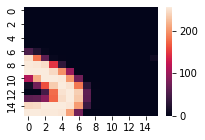

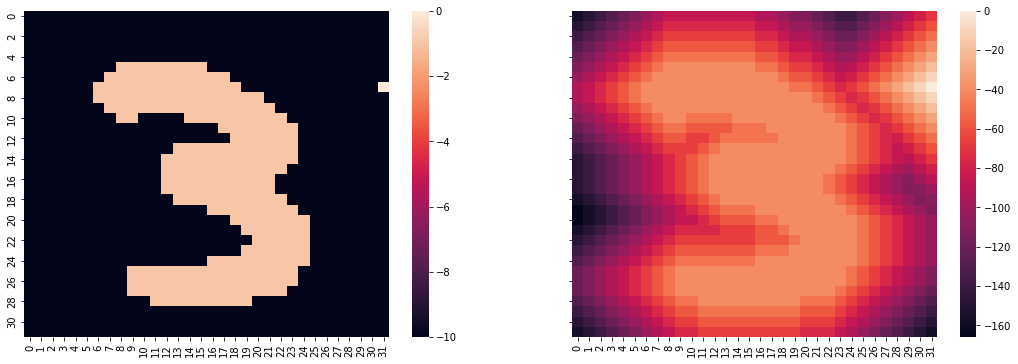

(32, 32) (32, 32)
7 31 = -73920.0
################################################################################
this is road
[(16, 0), (16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (16, 11), (16, 12), (16, 13), (16, 14), (16, 15), (17, 0), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (17, 15), (18, 0), (18, 1), (18, 2), (18, 3), (18, 4), (18, 5), (18, 6), (18, 7), (18, 8), (18, 9), (18, 10), (18, 11), (18, 12), (18, 13), (18, 14), (18, 15), (19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (20, 0), (20, 1), (20, 2), (20, 3), (20, 4), (20, 5), (20, 6), (20, 7), (20, 8), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (

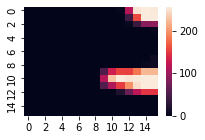

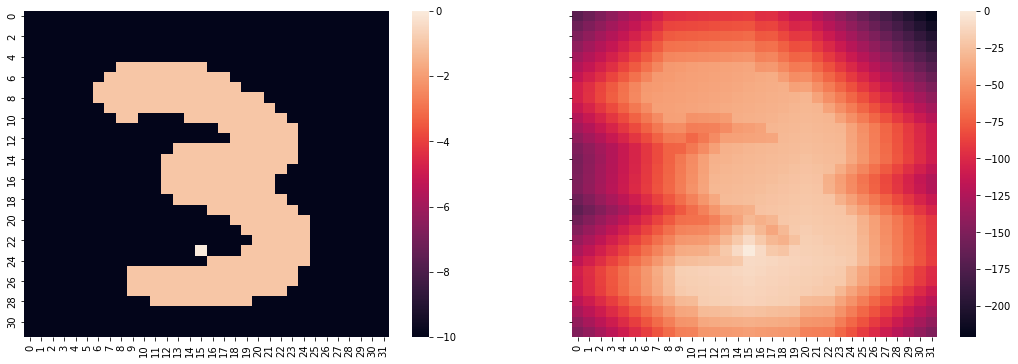

(32, 32) (32, 32)
23 15 = -72403.0
################################################################################
this is road
[(16, 16), (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25), (16, 26), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (17, 16), (17, 17), (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26), (17, 27), (17, 28), (17, 29), (17, 30), (17, 31), (18, 16), (18, 17), (18, 18), (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28), (18, 29), (18, 30), (18, 31), (19, 16), (19, 17), (19, 18), (19, 19), (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28), (19, 29), (19, 30), (19, 31), (20, 16), (20, 17), (20, 18), (20, 19), (20, 20), (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29), (20, 30), (20, 31), (21, 16), (21, 17), (21, 18), (21, 19), (21, 20), (21, 21), (21, 22), 

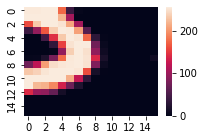

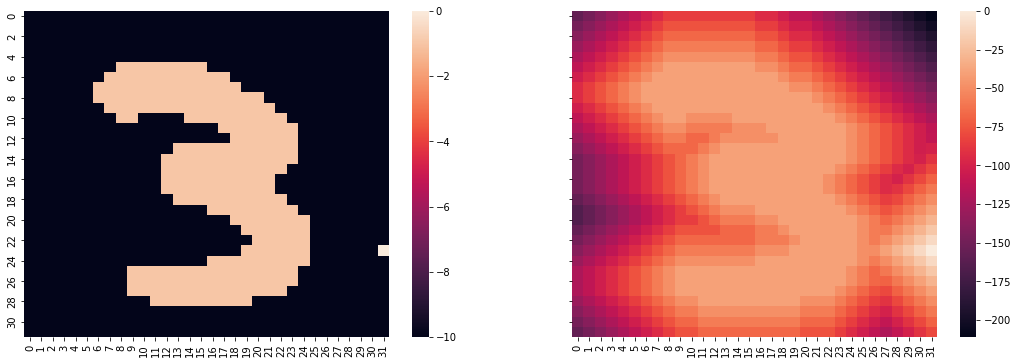

(32, 32) (32, 32)
23 31 = -77171.0
################################################################################
[(7, 15), (7, 31), (23, 15), (23, 31)]
++++++++++++++++++++++++++++++++++++++++
[-61651.0, -73920.0, -72403.0, -77171.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
7 15 : -61651.0


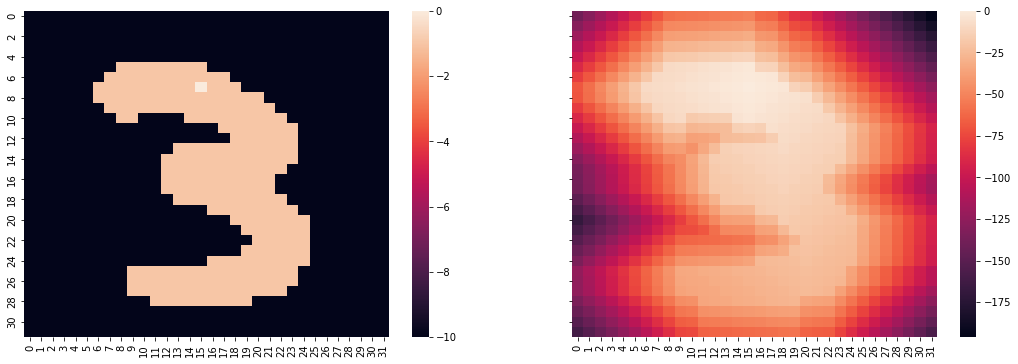

this is road
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
Calculating cost for (3, 7)


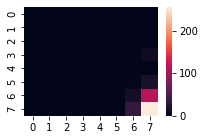

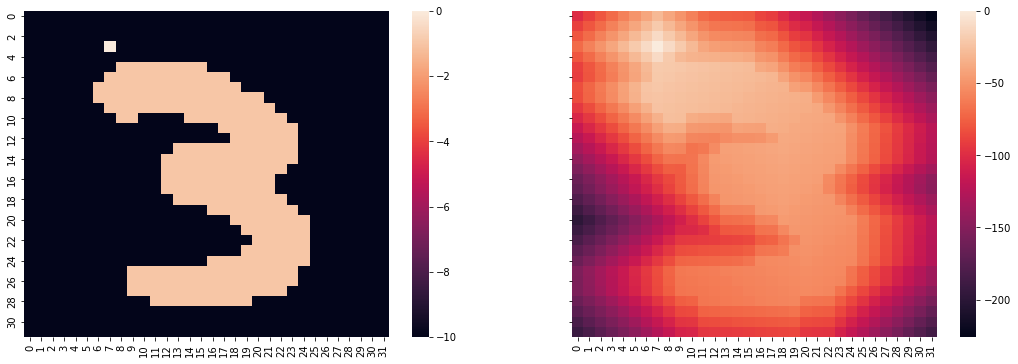

(32, 32) (32, 32)
3 7 = -86875.0
################################################################################
this is road
[(0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15)]
Calculating cost for (3, 15)


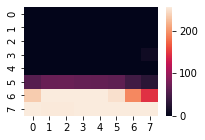

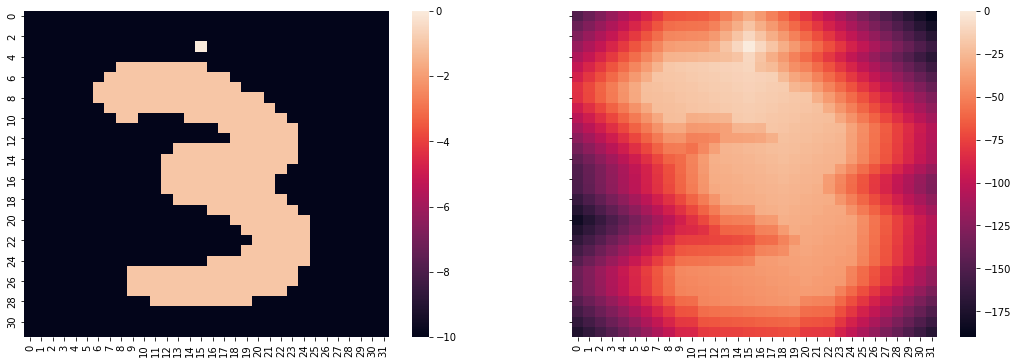

(32, 32) (32, 32)
3 15 = -72839.0
################################################################################
this is road
[(8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (14, 0), (14, 1), (14, 2), (14, 3), (14, 4), (14, 5), (14, 6), (14, 7), (15, 0), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (15, 7)]
Calculating cost for (11, 7)


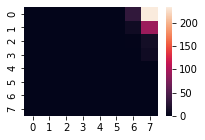

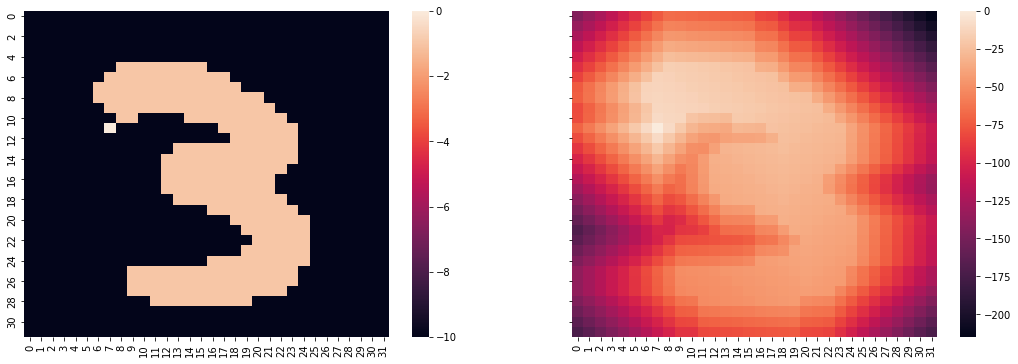

(32, 32) (32, 32)
11 7 = -74242.0
################################################################################
this is road
[(8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 8), (12, 9), (12, 10), (12, 11), (12, 12), (12, 13), (12, 14), (12, 15), (13, 8), (13, 9), (13, 10), (13, 11), (13, 12), (13, 13), (13, 14), (13, 15), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (14, 13), (14, 14), (14, 15), (15, 8), (15, 9), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15)]
Calculating cost for (11, 15)


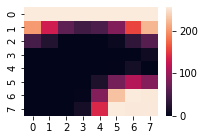

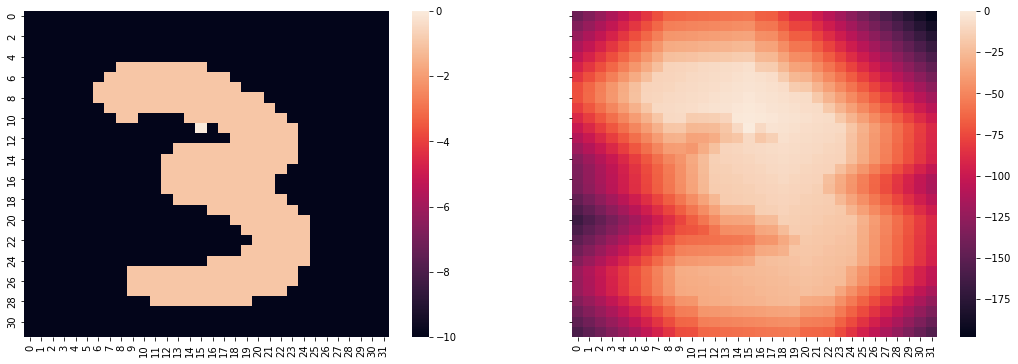

(32, 32) (32, 32)
11 15 = -61225.0
################################################################################
[(3, 7), (3, 15), (11, 7), (11, 15)]
++++++++++++++++++++++++++++++++++++++++
[-86875.0, -72839.0, -74242.0, -61225.0]
++++++++++++++++++++++++++++++++++++++++
Optimal CS location
11 15 : -61225.0


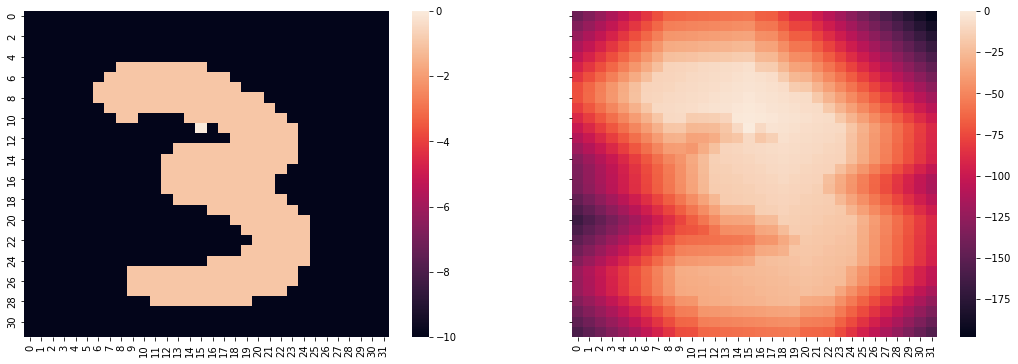

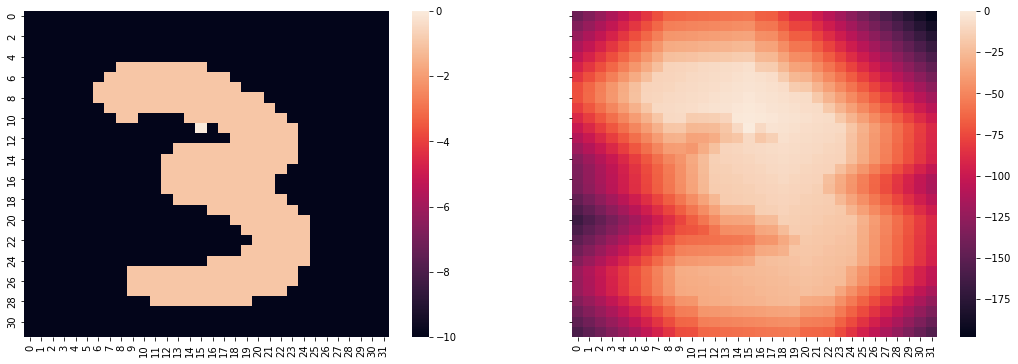

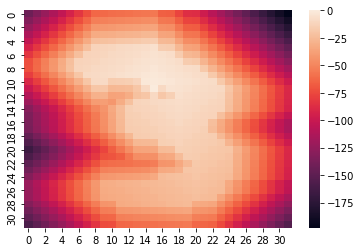

-143.0 -159.0 -198.0 -155.0 sum:  -655.0


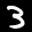

In [27]:
from PIL import Image
for i in range(5,15):
    img=Test_Set.iloc[i,:].values#.as_matrix()
    img=img.reshape((28,28))
    j1= Image.fromarray(img.astype(np.uint8), 'L')
    type(j1)
    test_pre[i,:]= Image_array(j1)

In [28]:
st= pd.DataFrame(test_pre,columns=['f1','f2','f3','f4','f5'])
st.head()

f1   f2   f3   f4   f5
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0

In [29]:
st.to_csv(f"test_modified_{sel}.csv",index=False)